This notebook contains BDT variables' distribution for signals of representative parameter points. Triggers, MetFilters and gen matching are applied.

**Mean lxy corresponds to 0.3 cm**

In the last part, signal's fractions with different dphi cut was plotted.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
from awkward import JaggedArray

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_   = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [3]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dict(files=dataset4mu_['mXX-100_mA-5_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dict(files=dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5_lxy-0p3': dict(files=dataset2mu2e_['mXX-100_mA-5_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dict(files=dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
}

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [4]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Selected datasets')
        pt0_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 200) # small range
        pt1_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 1500) # large range
        mass_axis     = hist.Bin("mass", "mass [GeV]", 50, 0, 25)
        
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 750)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 2000)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt0': hist.Hist("norm. counts/4GeV", dataset_axis, pt0_axis),
            'pt1': hist.Hist("norm. counts/30GeV", dataset_axis, pt1_axis),
            'mass': hist.Hist("norm. counts/0.5GeV", dataset_axis, mass_axis),
            
            "eta": hist.Hist("norm. counts/0.096", dataset_axis, eta_axis),
            "nef": hist.Hist("norm. counts/0.02", dataset_axis, nef_axis),
            "maxd0": hist.Hist("norm. counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("norm. counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("norm. counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("norm. counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("norm. counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("norm. counts/0.002", dataset_axis, spreaddr_axis),
            "lamb": hist.Hist("norm. counts/0.16", dataset_axis, lambda_axis),
            "epsi": hist.Hist("norm. counts/0.005", dataset_axis, epsilon_axis),
            "ecfe1": hist.Hist("norm. counts/15", dataset_axis, ecfe1_axis),
            "ecfe2": hist.Hist("norm. counts/40", dataset_axis, ecfe2_axis),
            "ecfe3": hist.Hist("norm. counts/20", dataset_axis, ecfe3_axis),
            "mva": hist.Hist("norm. counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        maxd0_ = absd0.max()
        mind0_ = absd0.min()

        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        leptonjets_ = leptonjets[matchmask]
        
        wgt_lj = (leptonjets_.pt.ones_like()*weight).flatten()
        
        output['pt0']     .fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgt_lj)
        output['pt1']     .fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgt_lj)
        output['mass']    .fill(dataset=dataset, mass=leptonjets_.mass.flatten(), weight=wgt_lj)
        output['eta']     .fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgt_lj)
        output['nef']     .fill(dataset=dataset, nef=leptonjets_.nef.flatten(), weight=wgt_lj)
        output['maxd0']   .fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgt_lj)
        output['mind0']   .fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgt_lj)
        output['tkiso']   .fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgt_lj)
        output['pfiso']   .fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weight=wgt_lj)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgt_lj)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgt_lj)
        output['lamb']    .fill(dataset=dataset, lamb=leptonjets_.lamb.flatten(), weight=wgt_lj)
        output['epsi']    .fill(dataset=dataset, epsi=leptonjets_.epsi.flatten(), weight=wgt_lj)
        output['ecfe1']   .fill(dataset=dataset, ecfe1=leptonjets_.ecf1.flatten(), weight=wgt_lj)
        output['ecfe2']   .fill(dataset=dataset, ecfe2=leptonjets_.ecf2.flatten(), weight=wgt_lj)
        output['ecfe3']   .fill(dataset=dataset, ecfe3=leptonjets_.ecf3.flatten(), weight=wgt_lj)
        output['mva']     .fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgt_lj)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.30items/s]


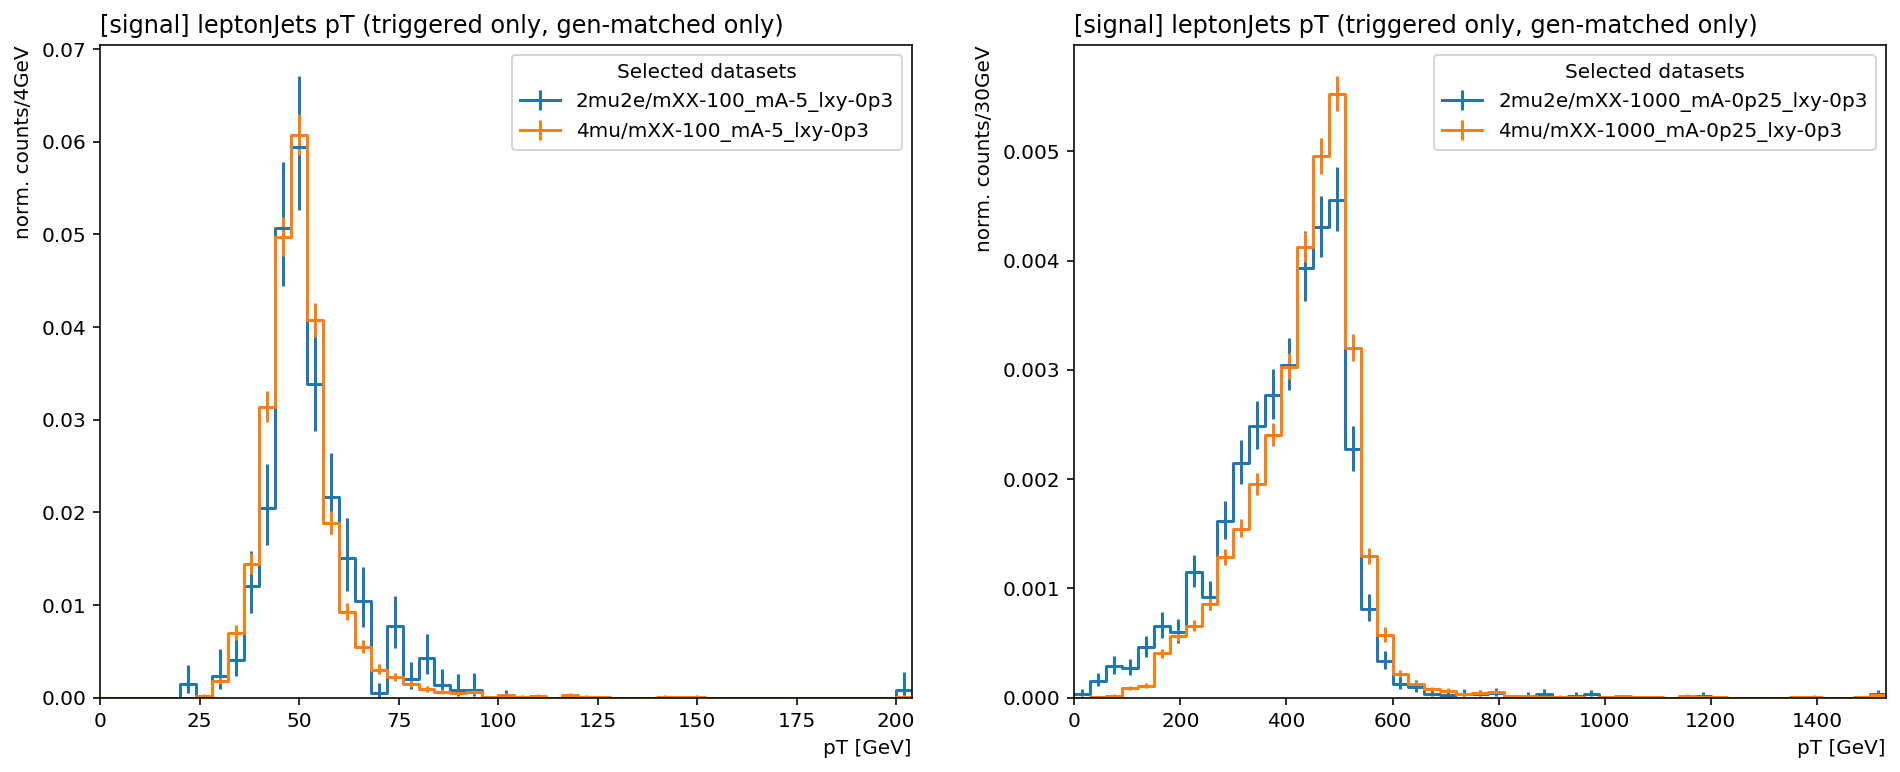

In [6]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig,ax,_ = hist.plot1d(output['pt0']['*/mXX-100_mA-5_lxy-0p3'], overlay='dataset', ax=axes[0], density=True, overflow='over')
fig,ax,_ = hist.plot1d(output['pt1']['*/mXX-1000_mA-0p25_lxy-0p3'], overlay='dataset', ax=axes[1], density=True, overflow='over')


for ax in axes:
#     ax.set_yscale('log')
    ax.set_title('[signal] leptonJets pT (triggered only, gen-matched only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

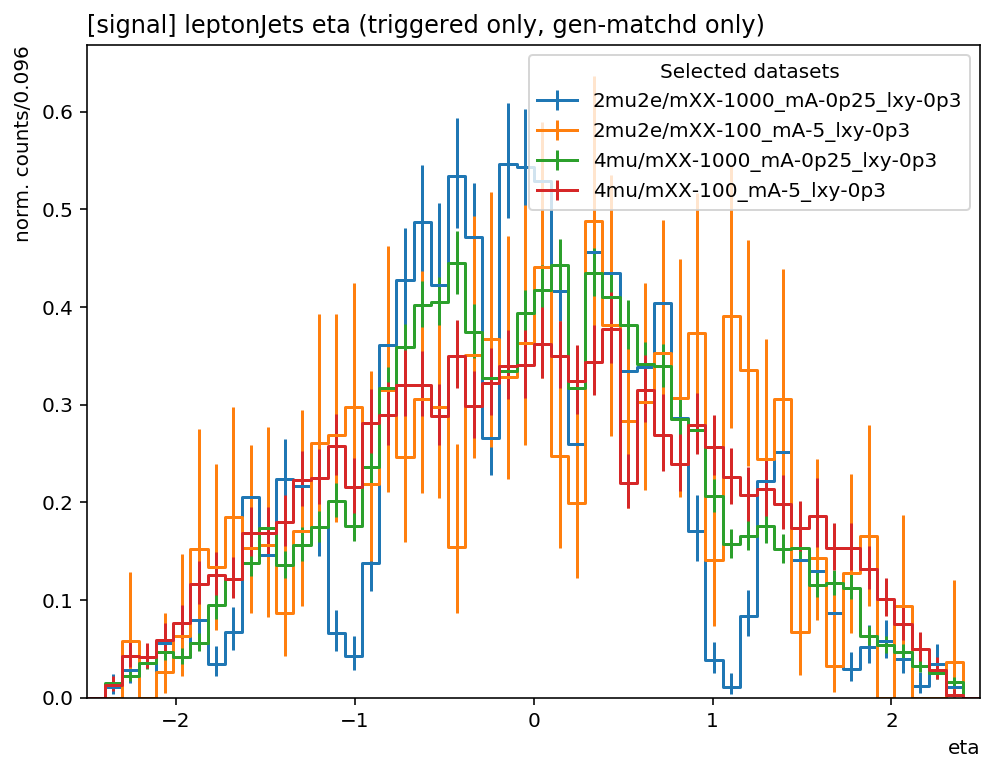

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['eta'], overlay='dataset', ax=ax, density=True, overflow='all')

# ax.set_yscale('log')
ax.set_title('[signal] leptonJets eta (triggered only, gen-matchd only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

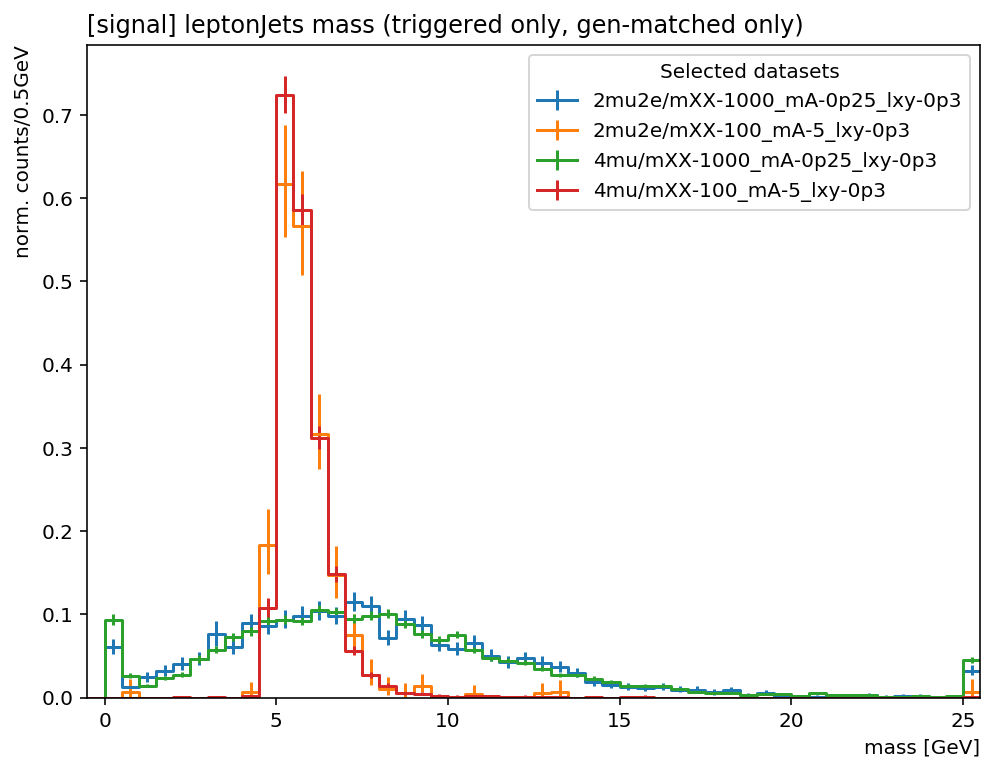

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['mass'], overlay='dataset', ax=ax, density=True, overflow='all')

# ax.set_yscale('log')
ax.set_title('[signal] leptonJets mass (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

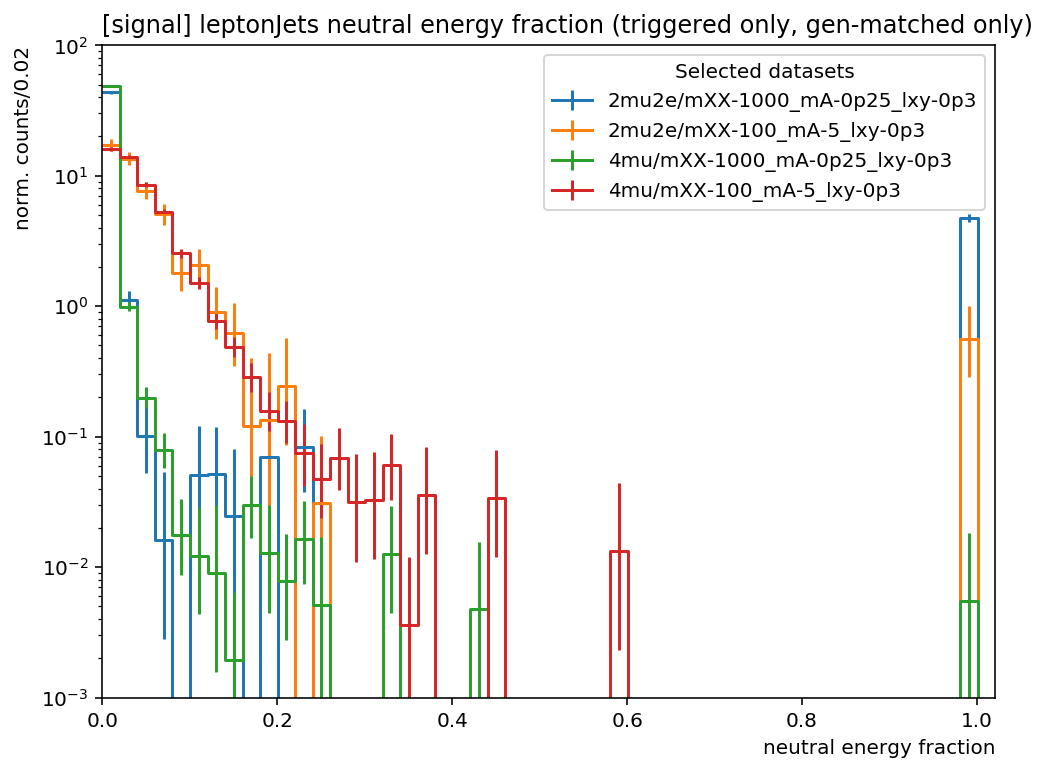

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['nef'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
ax.set_title('[signal] leptonJets neutral energy fraction (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

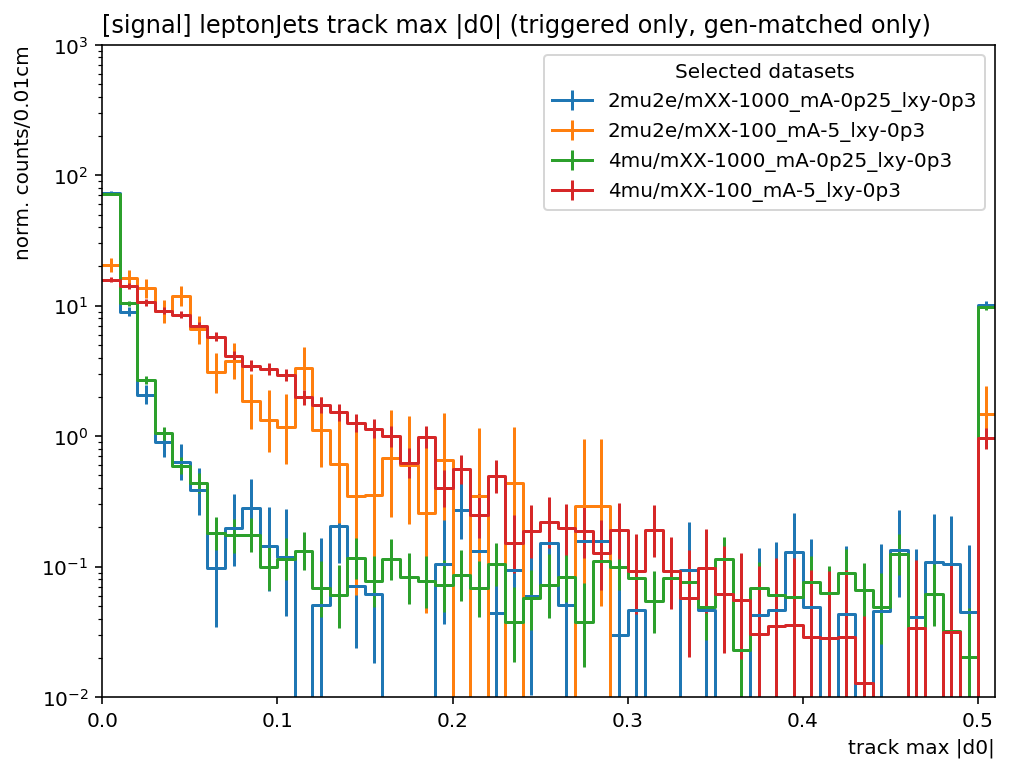

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['maxd0'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets track max |d0| (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

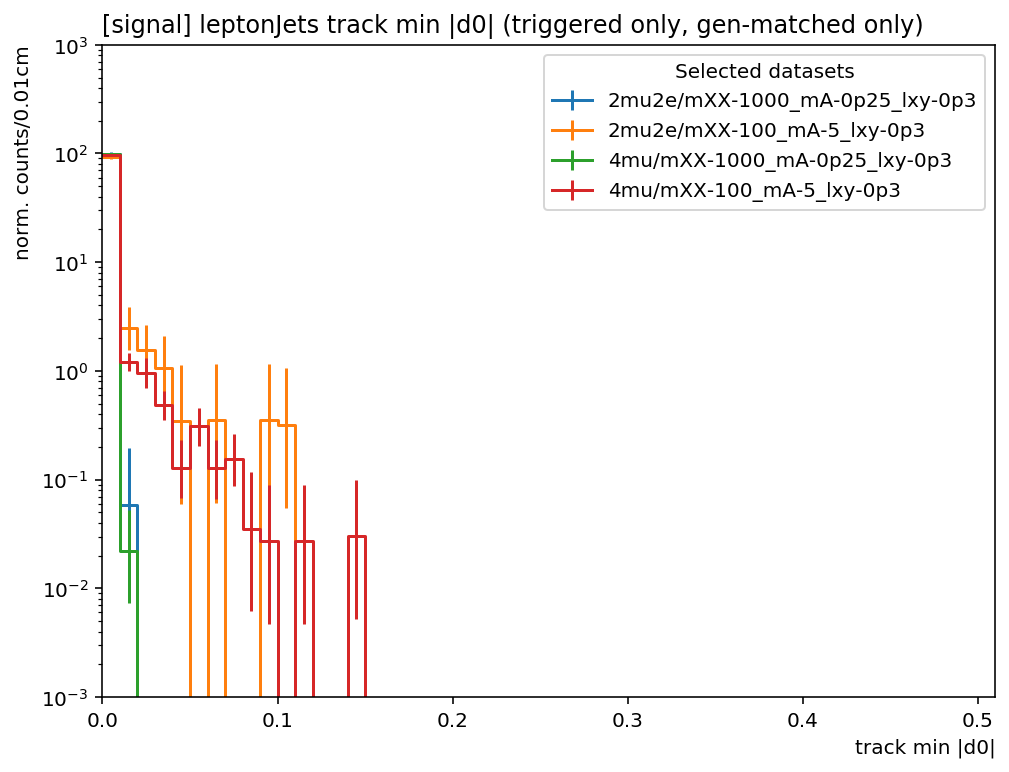

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['mind0'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-3, 1e3])
ax.set_title('[signal] leptonJets track min |d0| (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

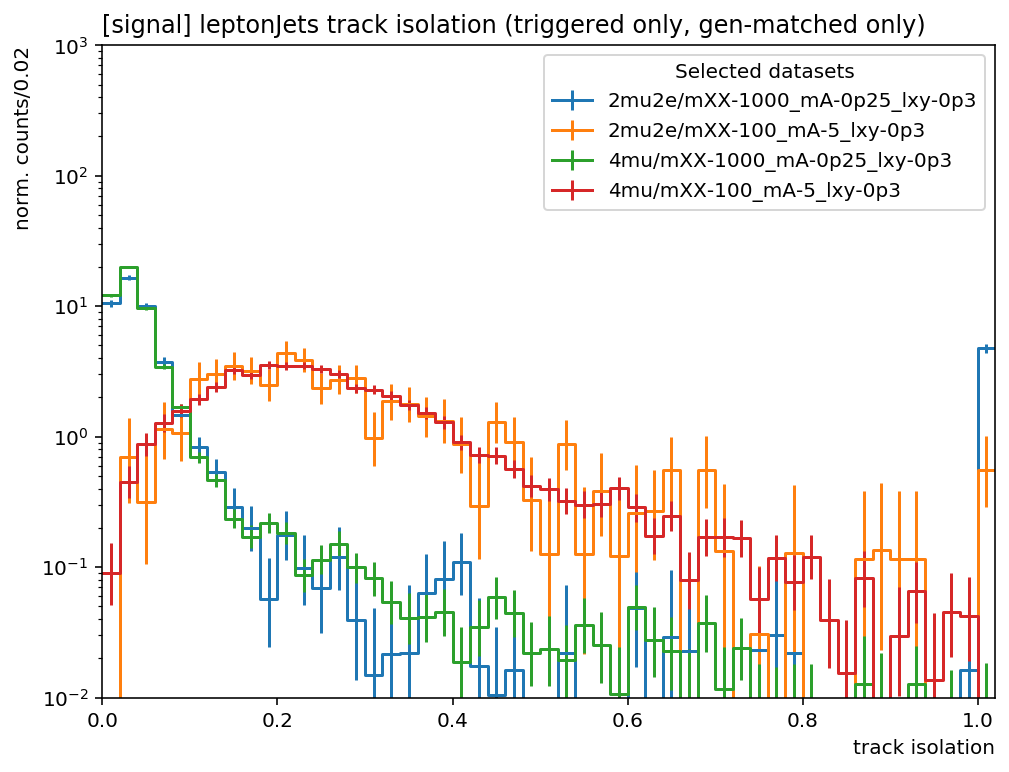

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['tkiso'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets track isolation (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

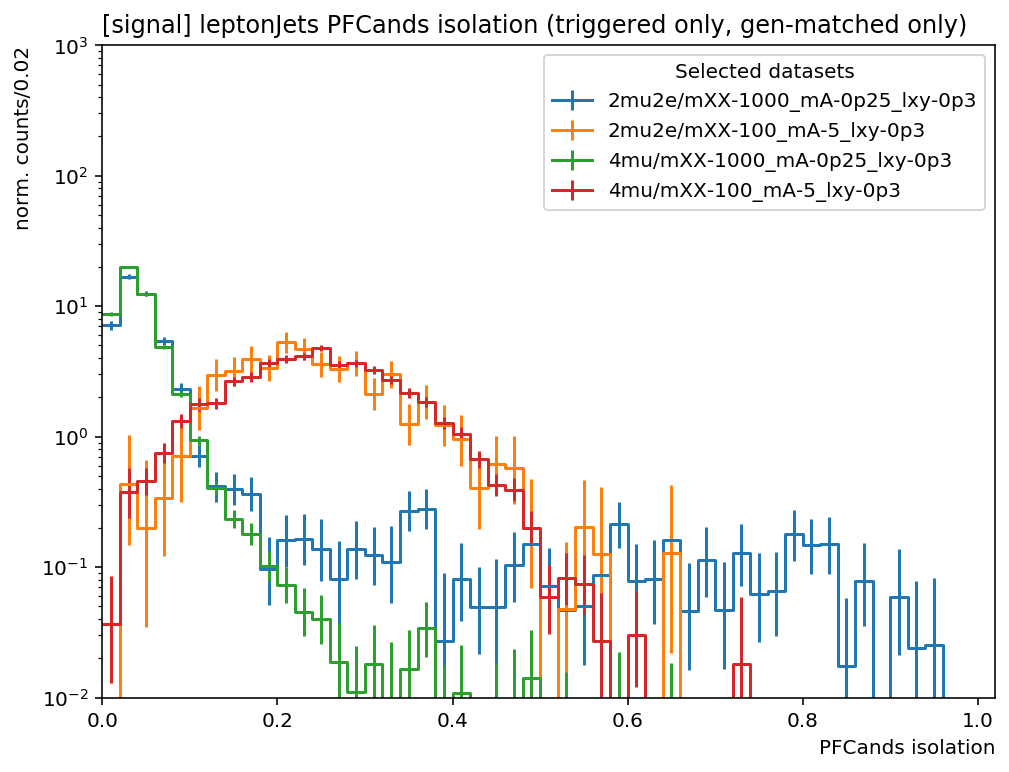

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['pfiso'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets PFCands isolation (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

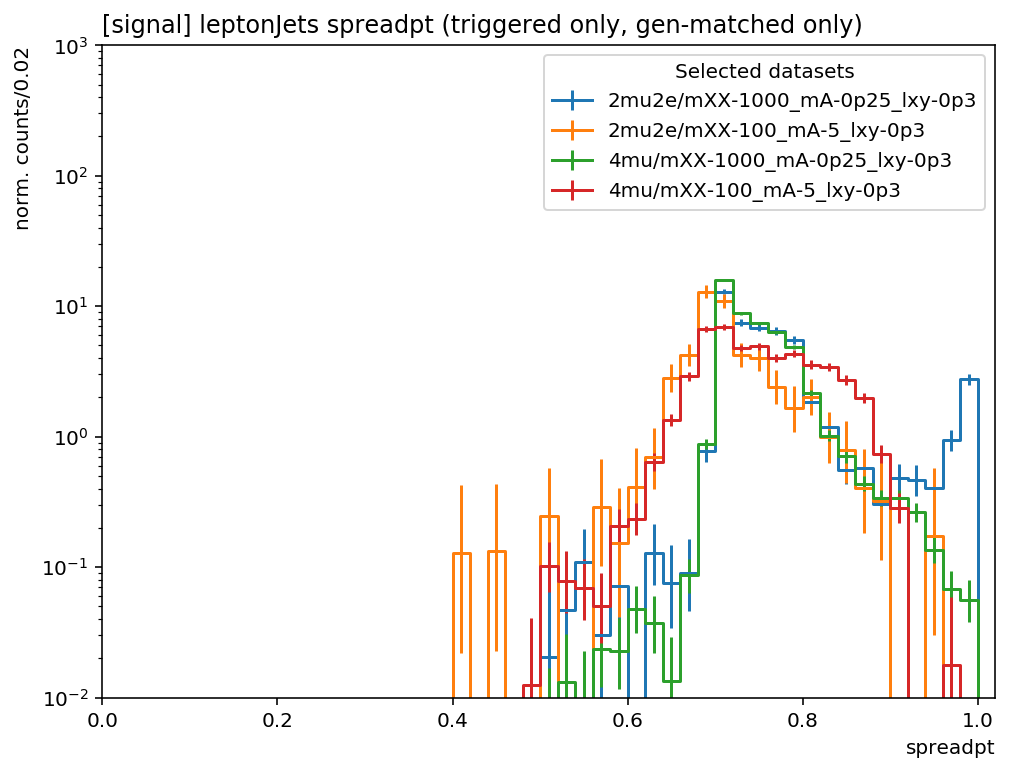

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['spreadpt'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets spreadpt (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

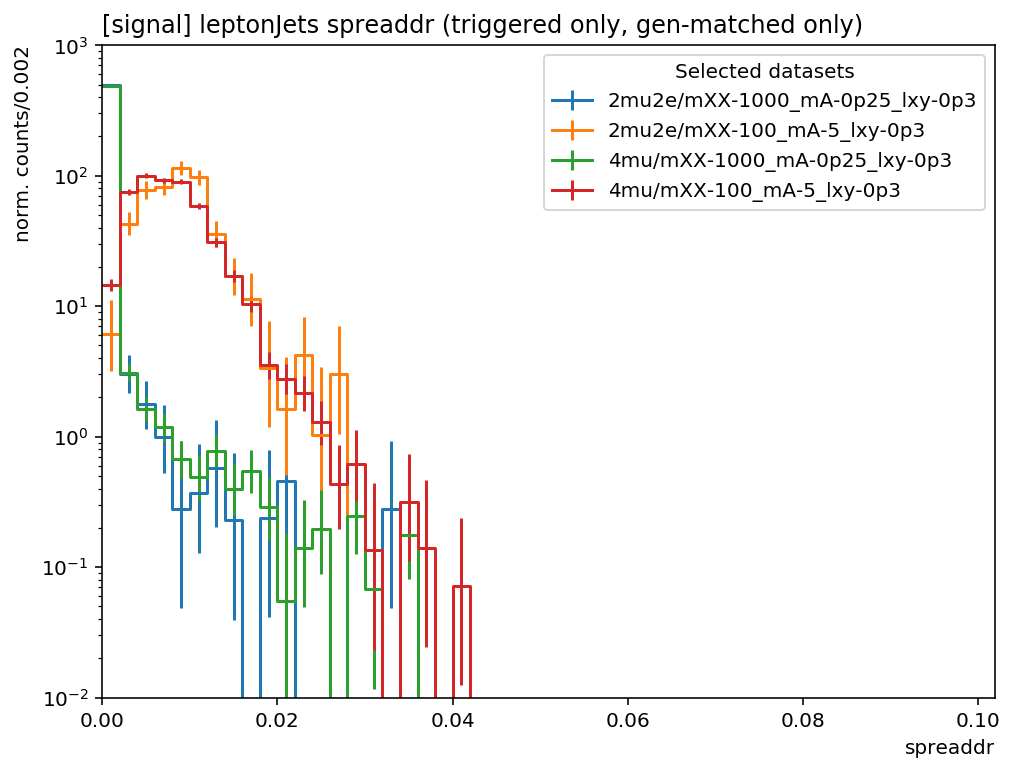

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['spreaddr'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets spreaddr (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

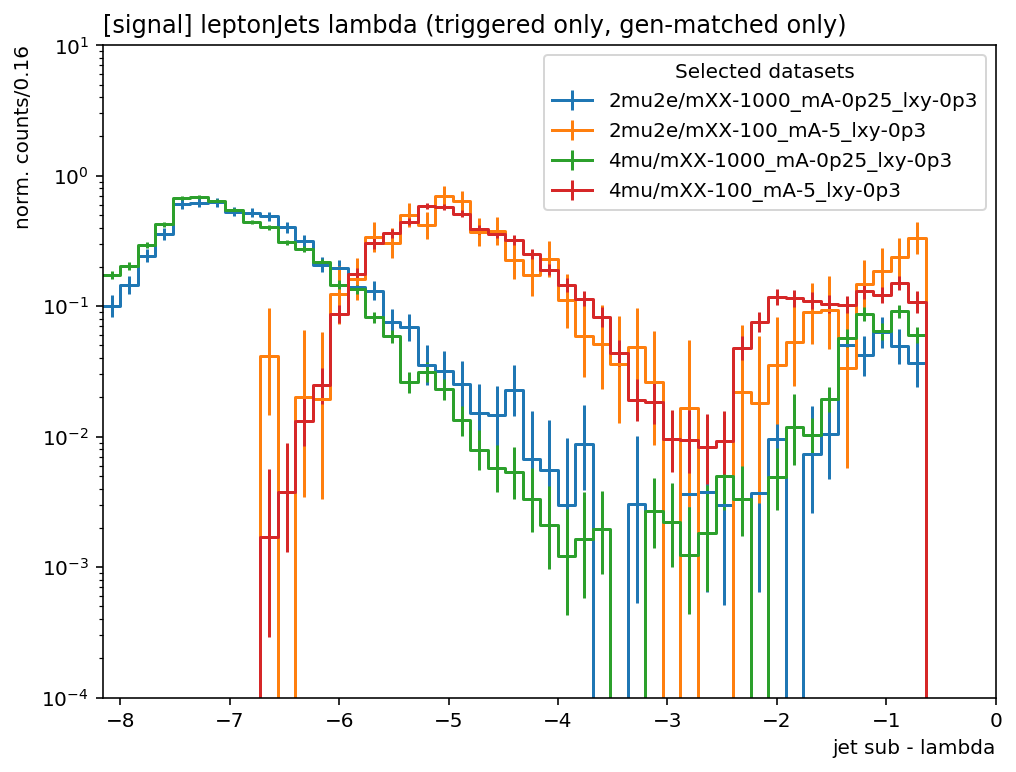

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['lamb'], overlay='dataset', ax=ax, density=True, overflow='under')

ax.set_yscale('log')
ax.set_ylim([1e-4, 1e1])
ax.set_title('[signal] leptonJets lambda (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

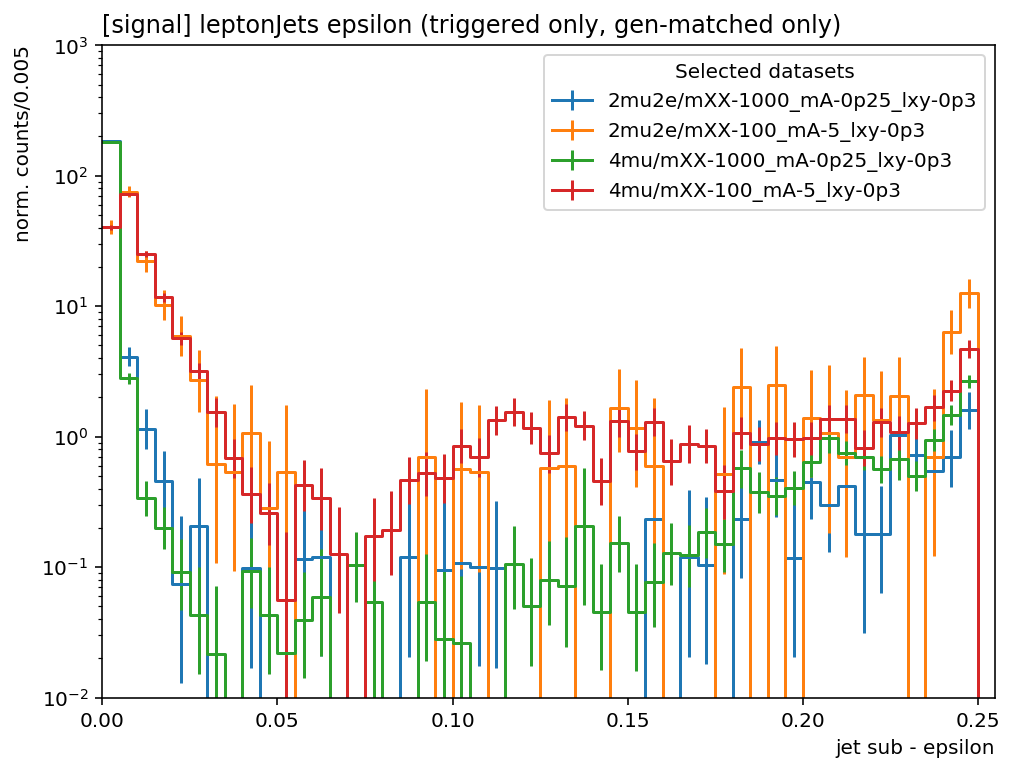

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['epsi'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets epsilon (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

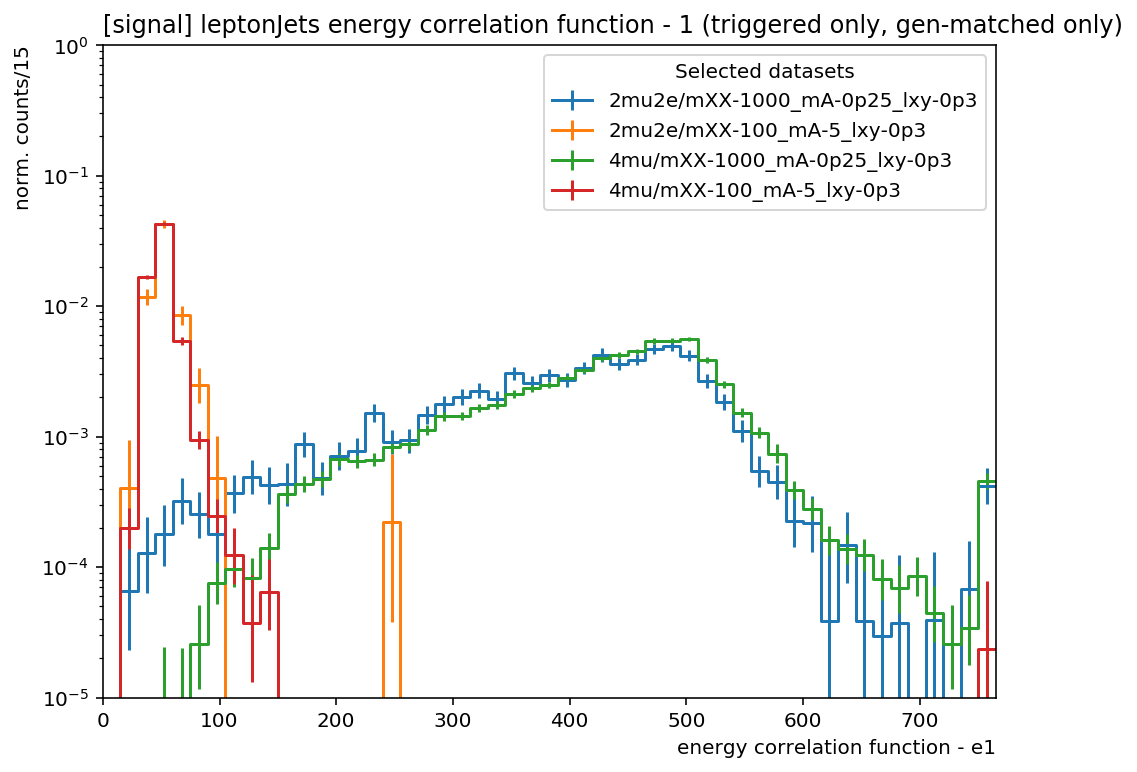

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['ecfe1'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets energy correlation function - 1 (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

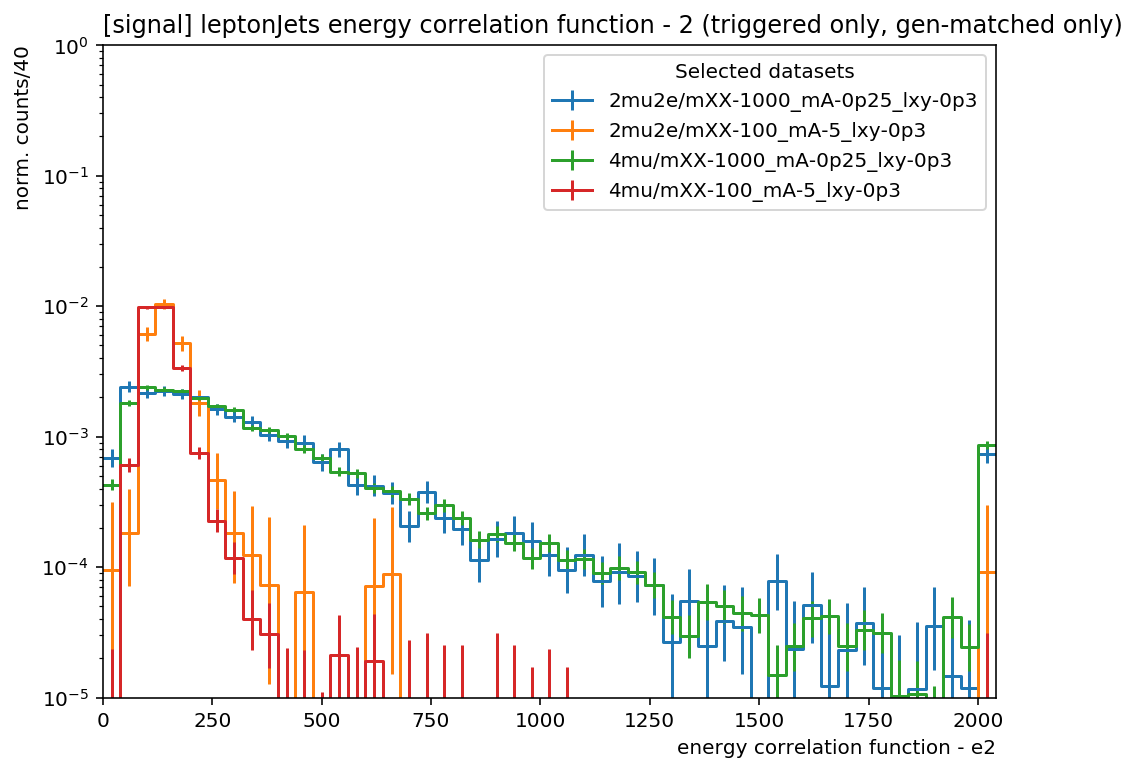

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['ecfe2'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets energy correlation function - 2 (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

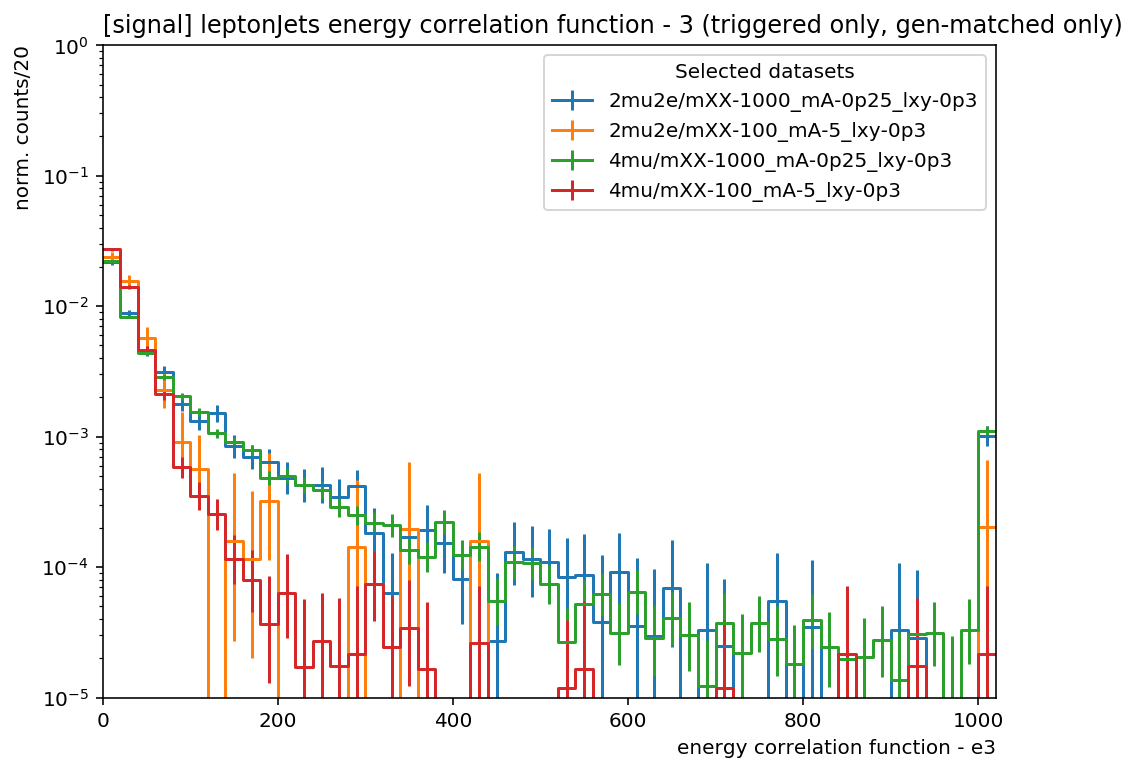

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['ecfe3'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets energy correlation function - 3 (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

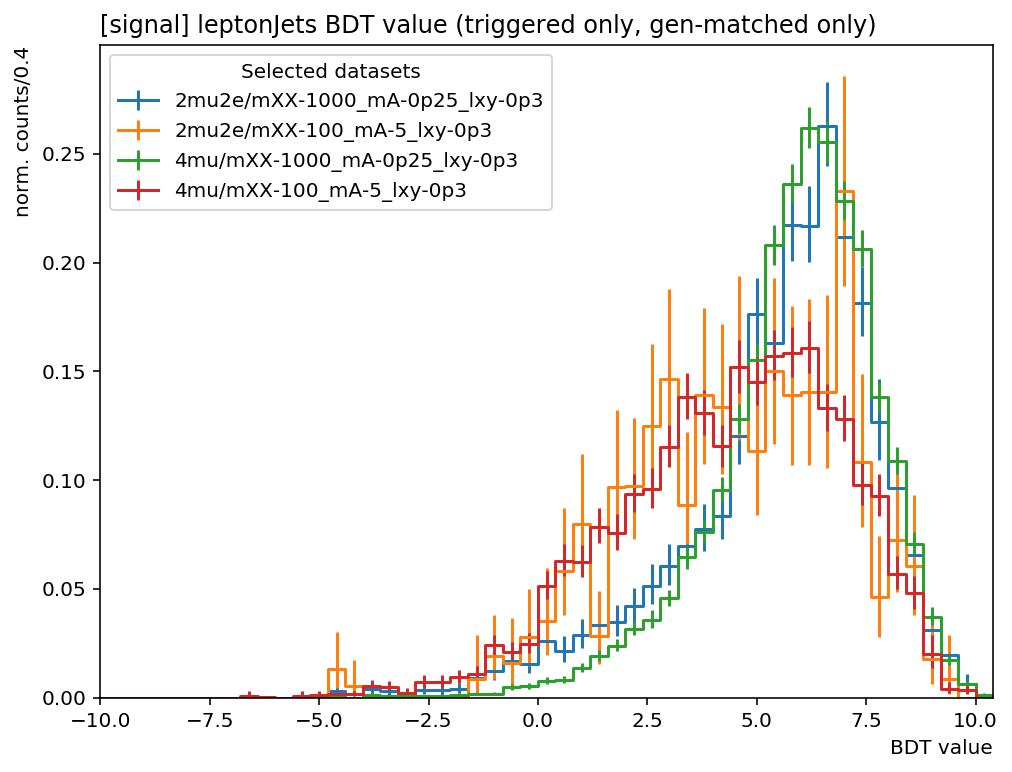

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['mva'], overlay='dataset', ax=ax, density=True, overflow='over')

# ax.set_yscale('log')
# ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets BDT value (triggered only, gen-matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leptonJet pair

matching with gen darkphotons

In [6]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'selected datasets')
        mass0_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 200) # small range
        mass1_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 2000) # large range
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass0': hist.Hist("norm. counts/4GeV", dataset_axis, mass0_axis),
            'mass1': hist.Hist("norm. counts/40GeV", dataset_axis, mass1_axis),
            'dphi': hist.Hist("norm. counts/$\pi$/50", dataset_axis, dphi_axis),
            'dphimass': hist.Hist("norm. counts/$\pi$/50/40GeV", dataset_axis, dphi_axis, mass1_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        leptonjets = leptonjets[matchmask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt

        leadingLjPair = leptonjetpair[sumpt.argmax()]
        dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))

        output['mass0'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten(), weight=wgt)
        output['mass1'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi.flatten(), weight=wgt)
        output['dphimass'].fill(dataset=dataset, dphi=dphi.flatten(), mass=leadingLjPair.mass.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [7]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  3.98items/s]


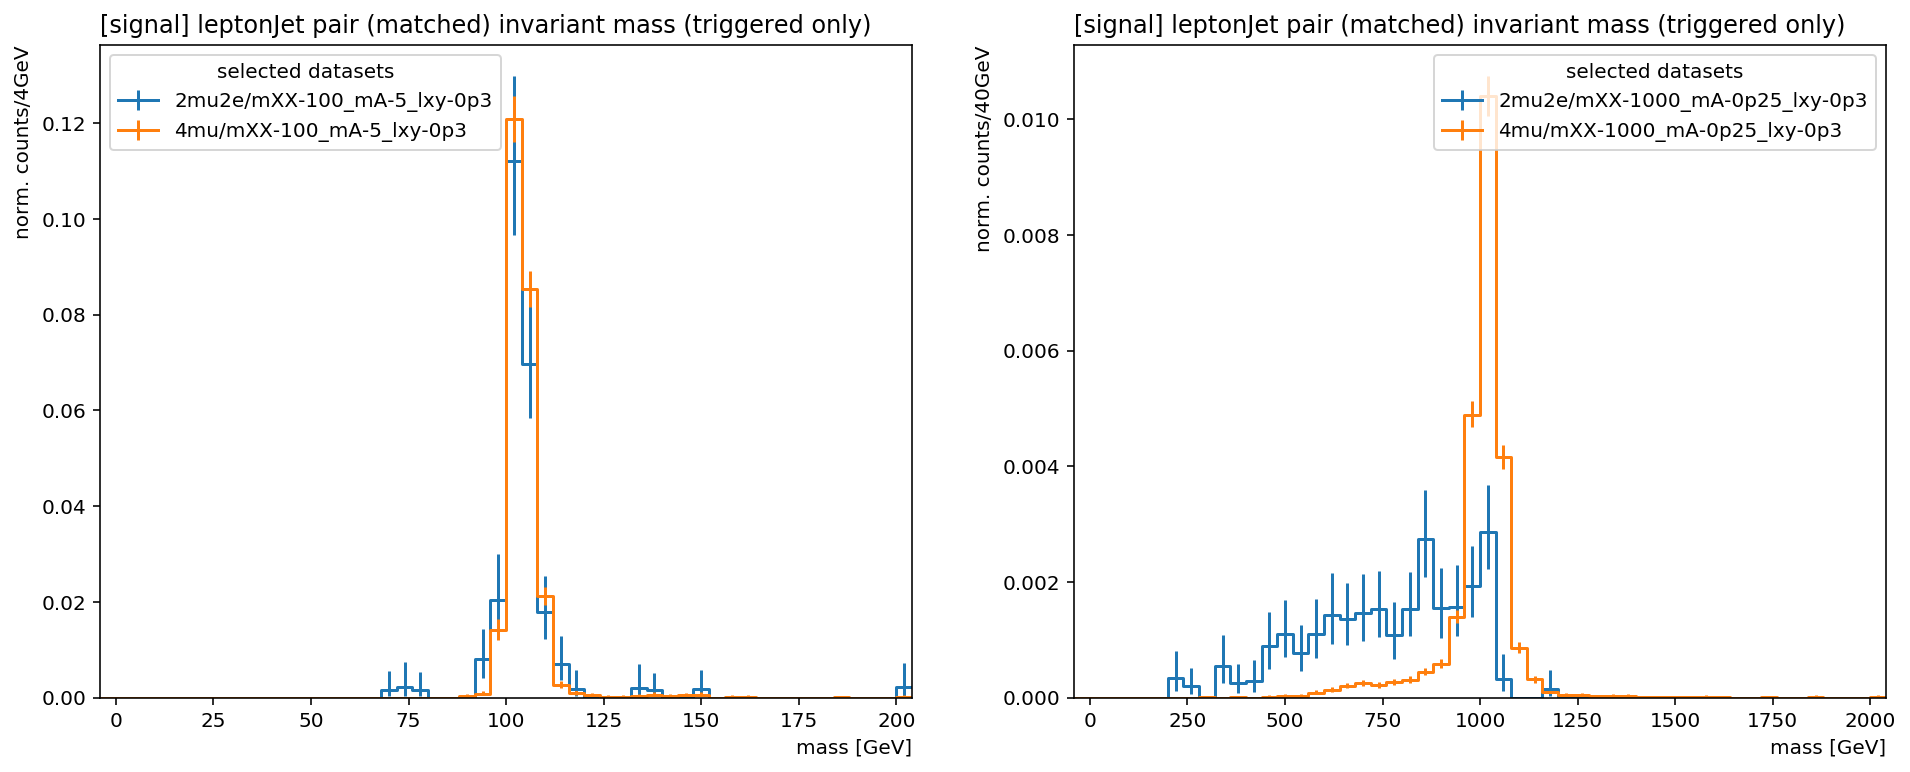

In [24]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig,ax,_ = hist.plot1d(output['mass0']['*/mXX-100_mA-5*'], overlay='dataset', ax=axes[0], density=True, overflow='all')
fig,ax,_ = hist.plot1d(output['mass1']['*/mXX-1000_mA-0p25*'], overlay='dataset', ax=axes[1], density=True, overflow='all')

for ax in axes:
#     ax.set_yscale('log')
    ax.set_title('[signal] leptonJet pair (matched) invariant mass (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

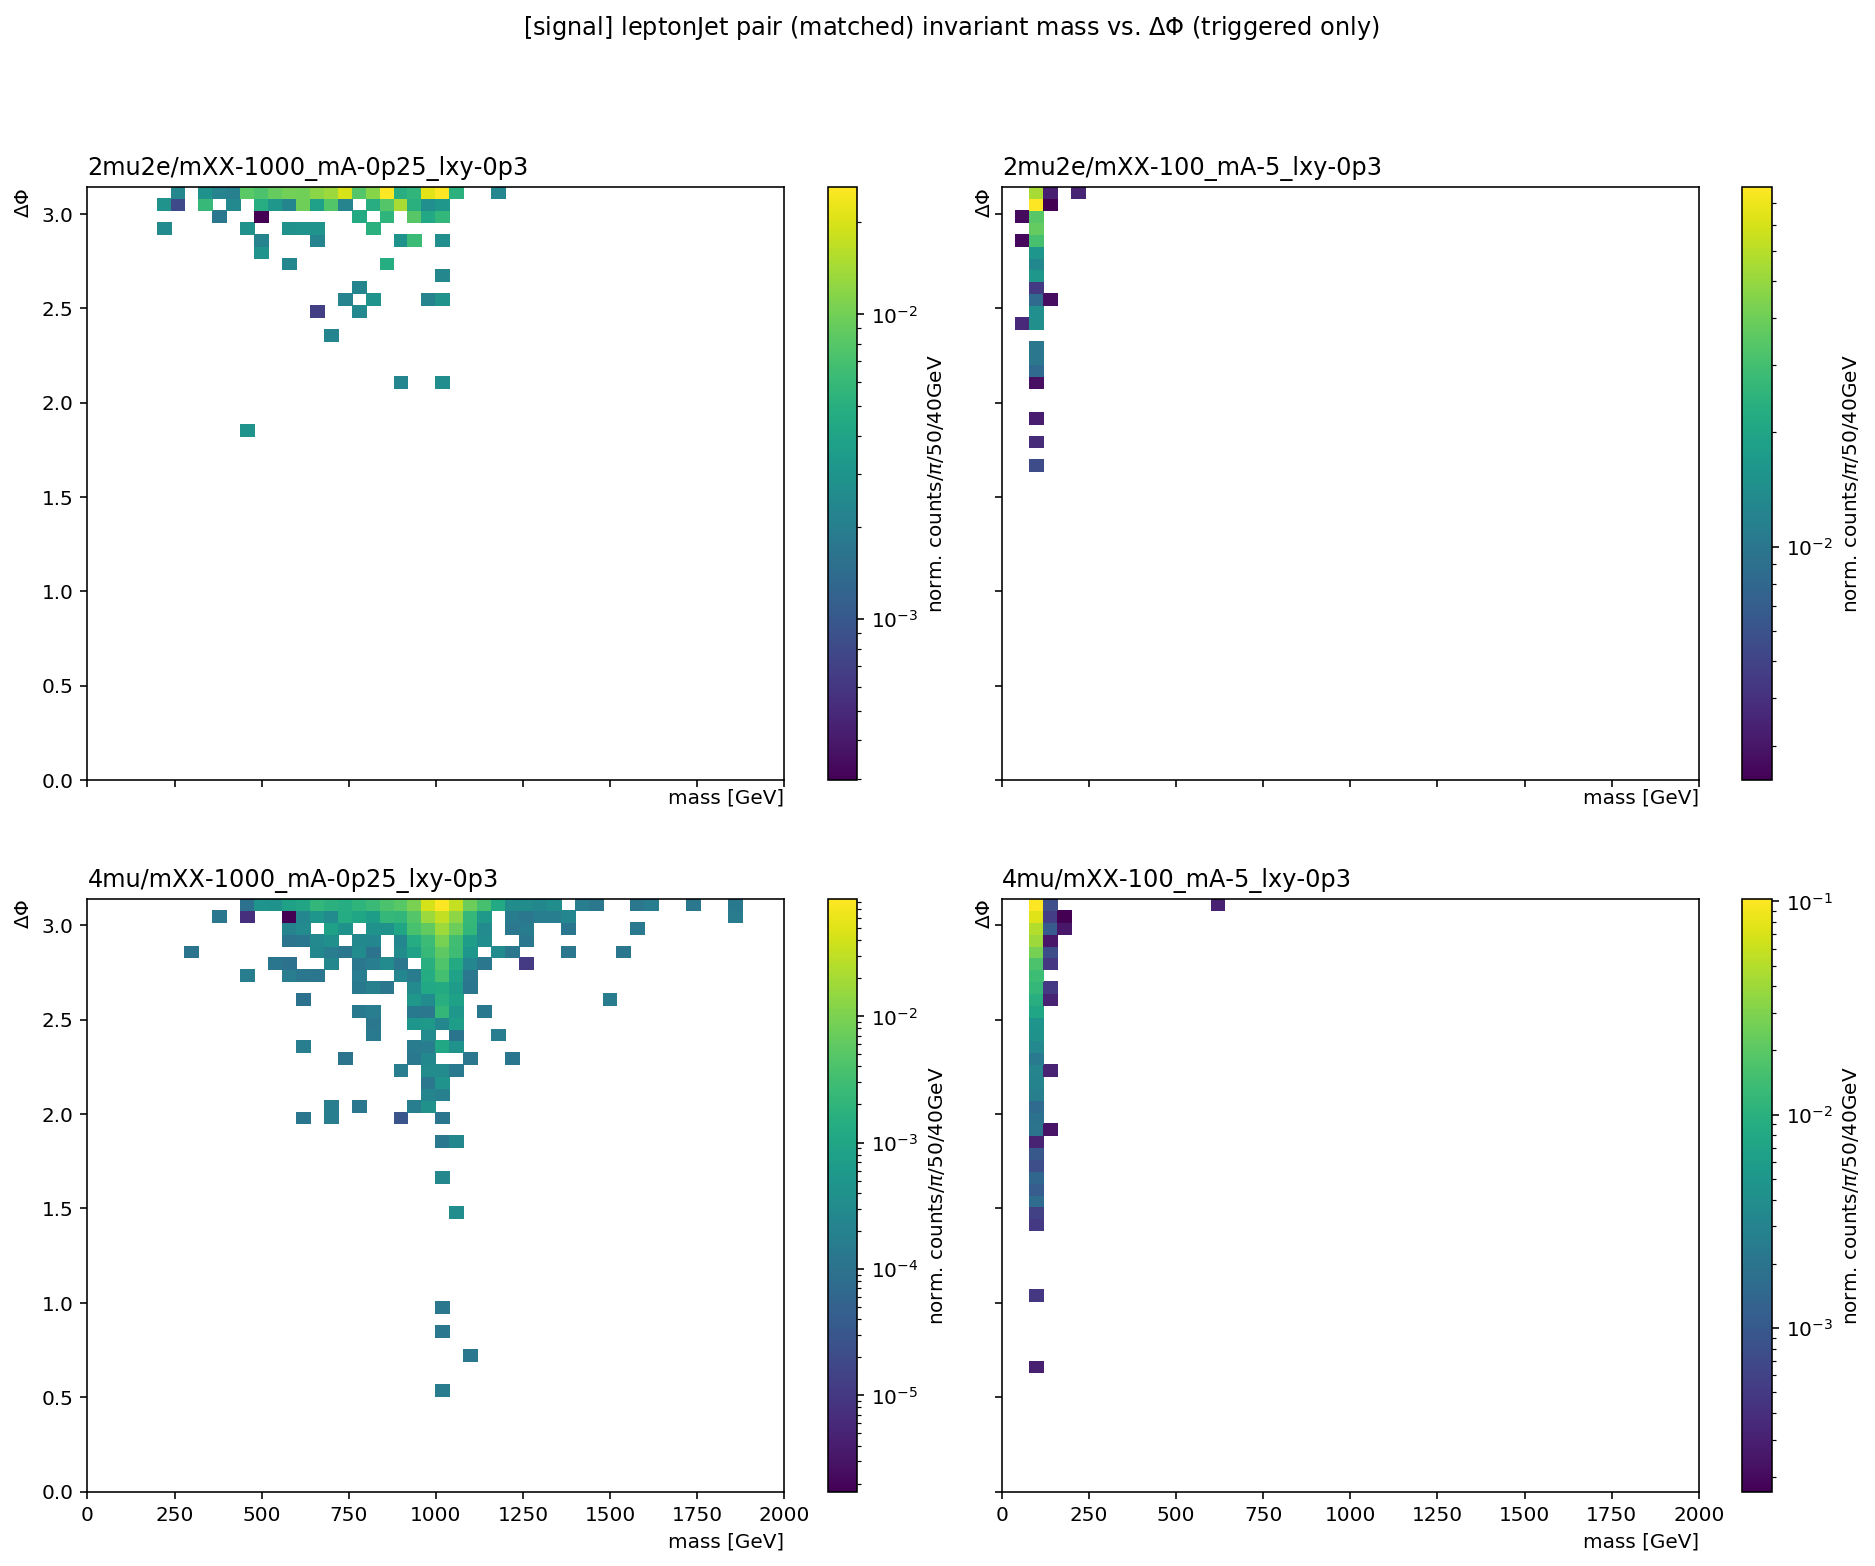

In [25]:
from matplotlib.colors import LogNorm
dsids = output['dphimass'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['dphimass'].project('dataset', dsids[i]), xaxis='mass', density=True, ax=ax, patch_opts=dict(norm=LogNorm()))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal] leptonJet pair (matched) invariant mass vs. $\Delta\Phi$ (triggered only)');

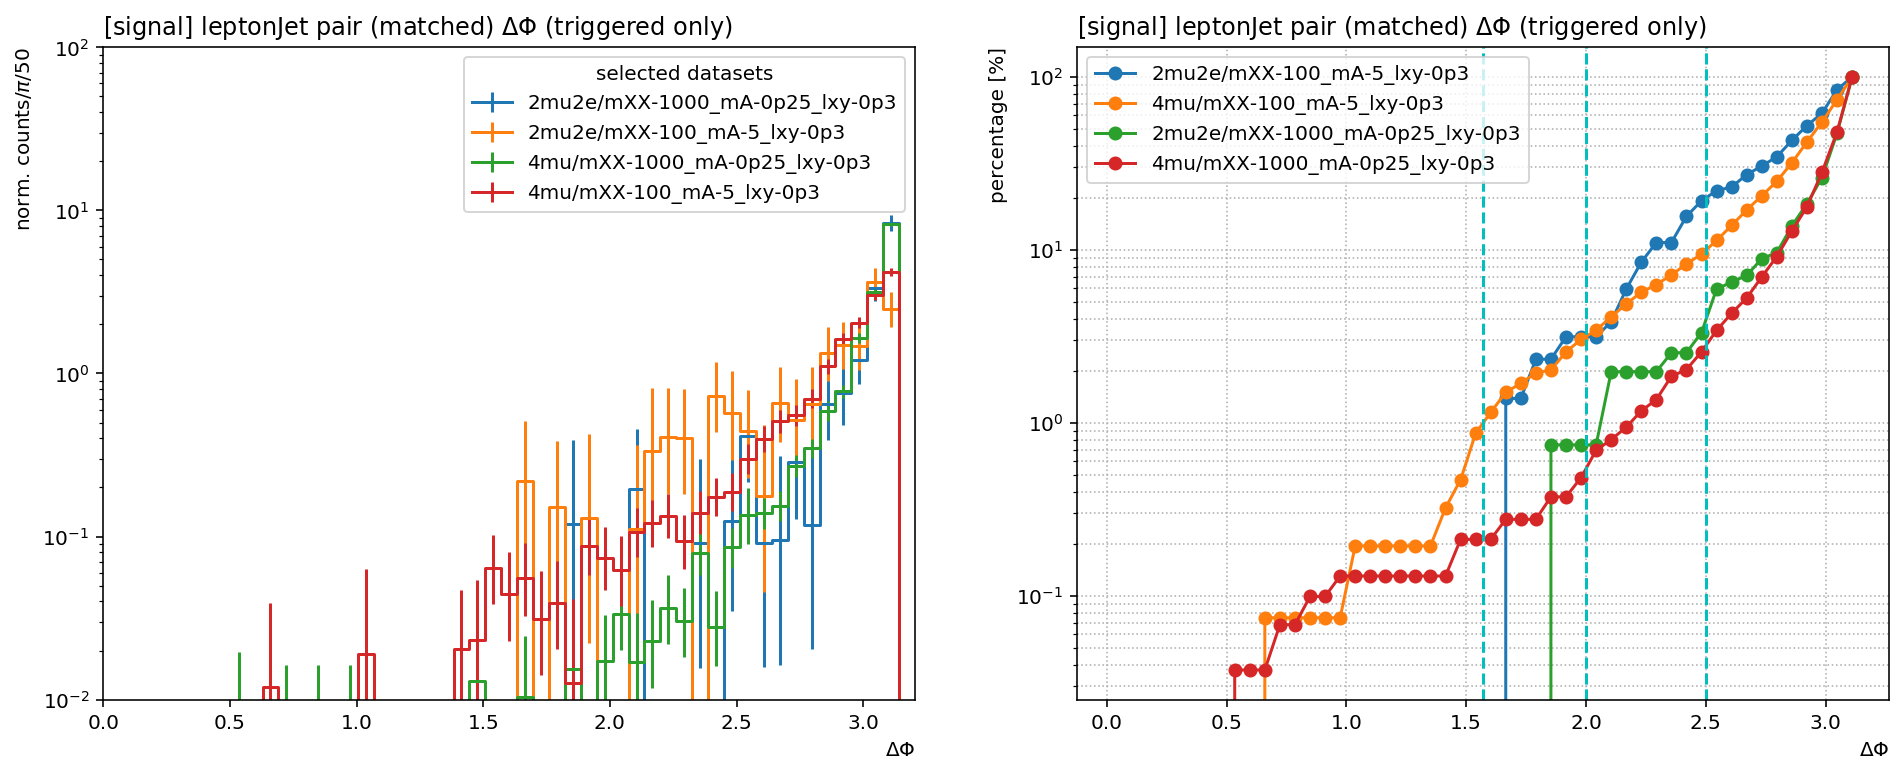

In [26]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['dphi'], overlay='dataset', ax=axes[0], density=True, overflow='over')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-2, 1e2])
axes[0].set_title('[signal] leptonJet pair (matched) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[0].set_xlabel(axes[0].get_xlabel(), x=1.0, ha="right")
axes[0].set_ylabel(axes[0].get_ylabel(), y=1.0, ha="right")

for d in output['dphi'].values():
    label_ = d[0]
    val = output['dphi'].values()[d]
    val_ = np.cumsum(val)/np.sum(val) * 100
    axes[1].plot(output['dphi'].axis('dphi').centers(), val_, marker='o', label=label_)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].grid(which='both', ls=':')
for i in [np.pi/2, 2, 2.5]:
    axes[1].axvline(i, color='c', ls='--') # cyan
axes[1].set_title('[signal] leptonJet pair (matched) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[1].set_xlabel('$\Delta\Phi$', x=1.0, ha="right")
axes[1].set_ylabel('percentage [%]', y=1.0, ha="right");

leading and subleading pair

In [8]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'selected datasets')
        mass0_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 200) # small range
        mass1_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 2000) # large range
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass0': hist.Hist("norm. counts/4GeV", dataset_axis, mass0_axis),
            'mass1': hist.Hist("norm. counts/40GeV", dataset_axis, mass1_axis),
            'dphi': hist.Hist("norm. counts/$\pi$/50", dataset_axis, dphi_axis),
            'dphimass': hist.Hist("norm. counts/$\pi$/50/40GeV", dataset_axis, dphi_axis, mass1_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))

        output['mass0'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten(), weight=wgt)
        output['mass1'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi.flatten(), weight=wgt)
        output['dphimass'].fill(dataset=dataset, dphi=dphi.flatten(), mass=leadingLjPair.mass.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [9]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  1.83items/s]


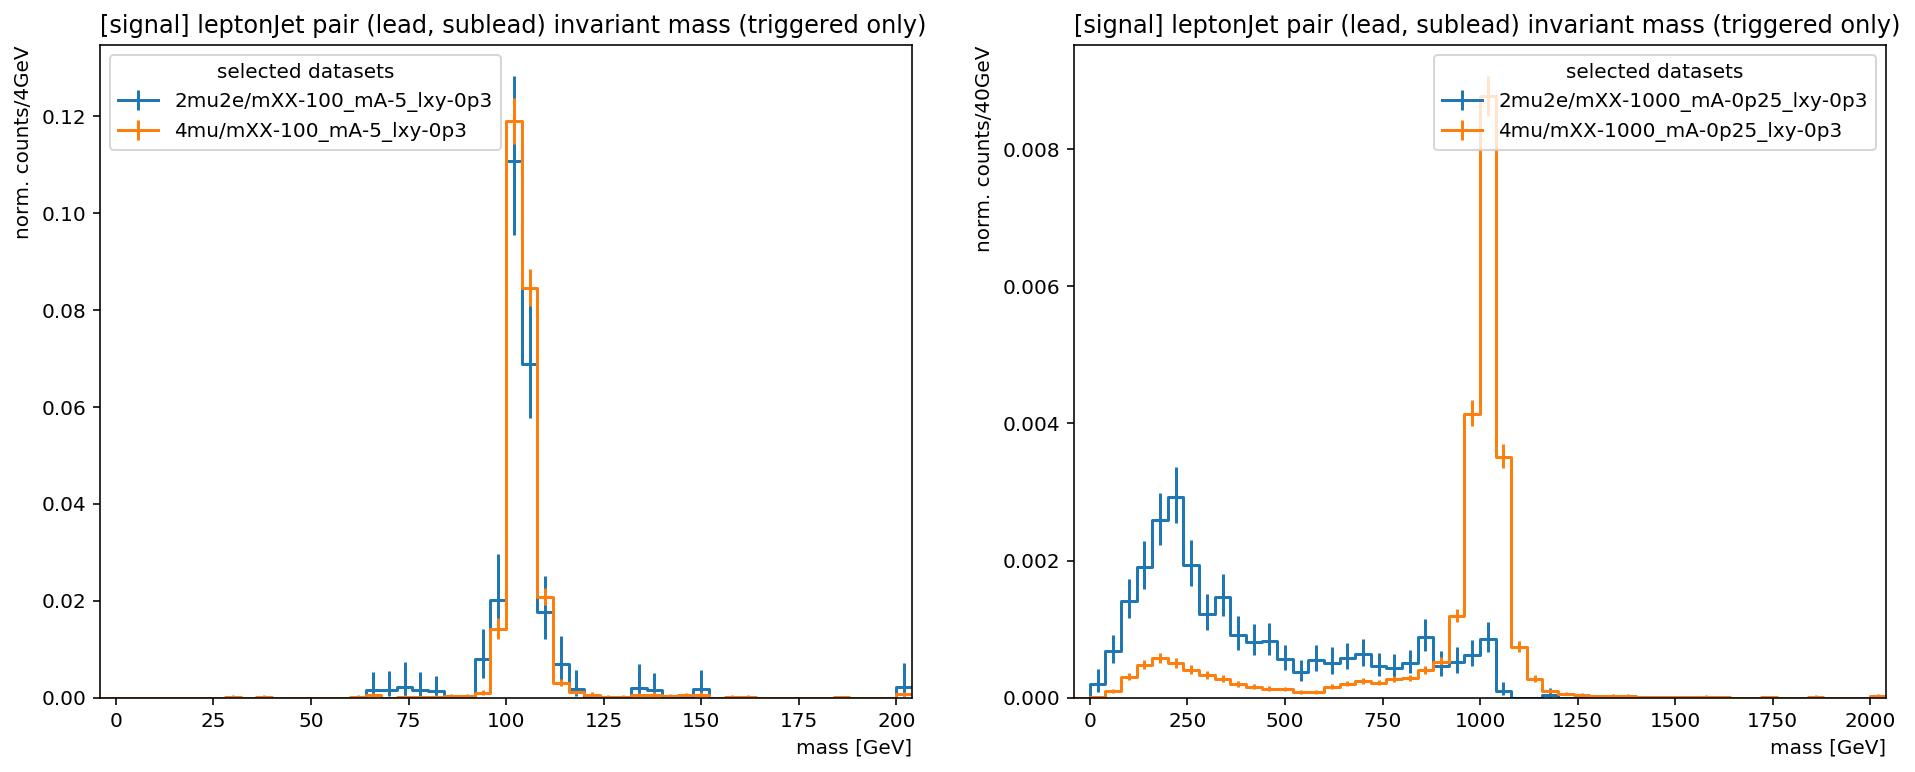

In [29]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig,ax,_ = hist.plot1d(output['mass0']['*/mXX-100_mA-5*'], overlay='dataset', ax=axes[0], density=True, overflow='all')
fig,ax,_ = hist.plot1d(output['mass1']['*/mXX-1000_mA-0p25*'], overlay='dataset', ax=axes[1], density=True, overflow='all')

for ax in axes:
#     ax.set_yscale('log')
    ax.set_title('[signal] leptonJet pair (lead, sublead) invariant mass (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

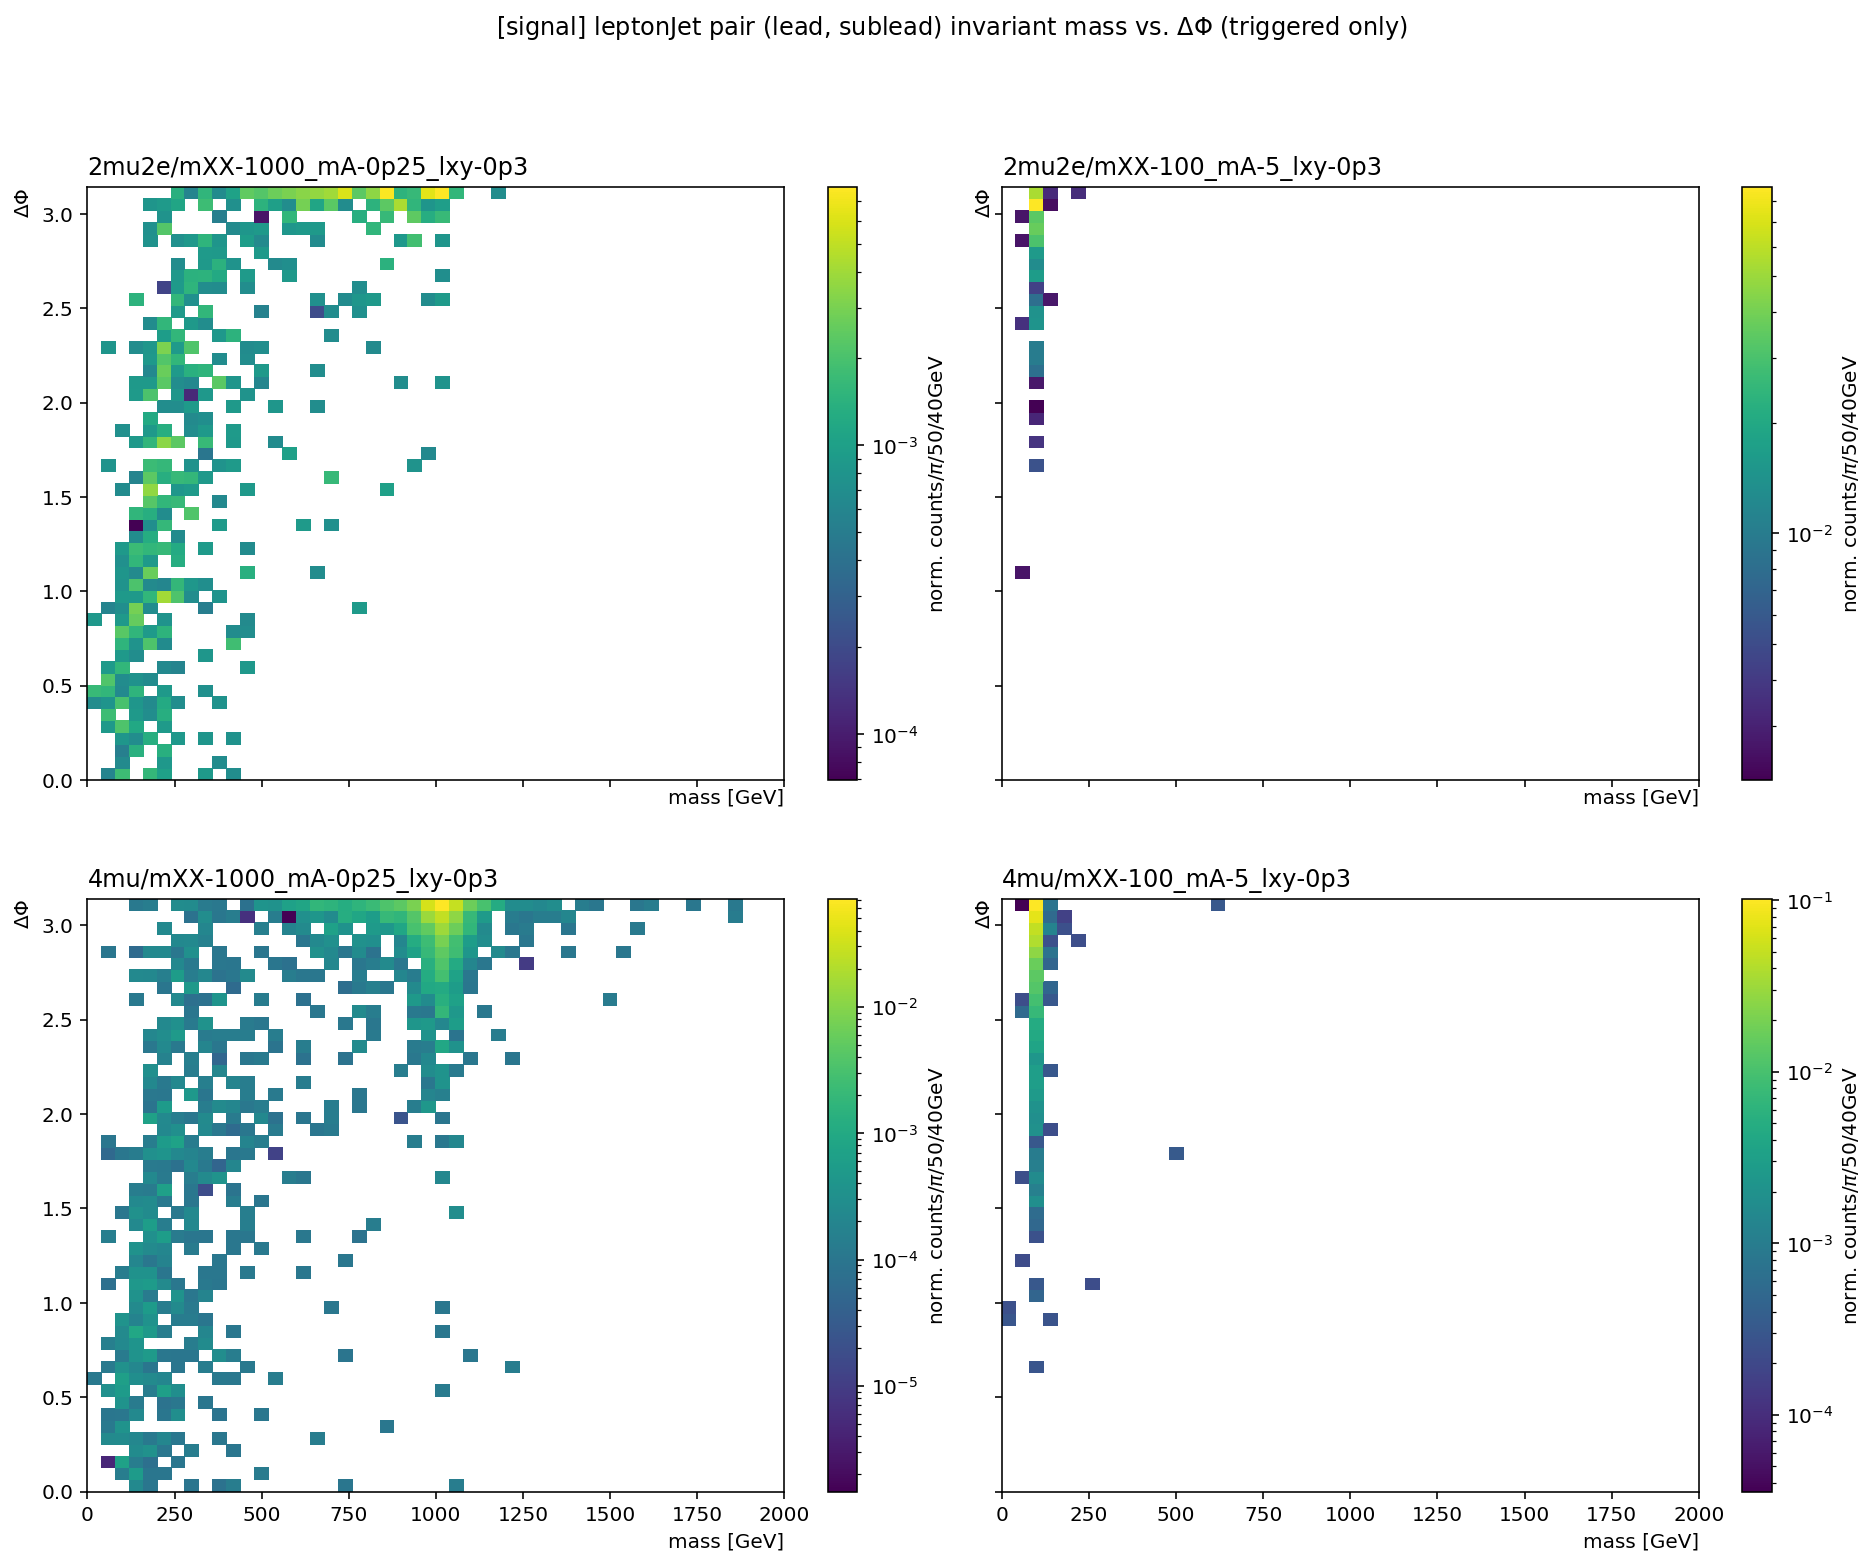

In [30]:
from matplotlib.colors import LogNorm
dsids = output['dphimass'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['dphimass'].project('dataset', dsids[i]), xaxis='mass', density=True, ax=ax, patch_opts=dict(norm=LogNorm()))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal] leptonJet pair (lead, sublead) invariant mass vs. $\Delta\Phi$ (triggered only)');

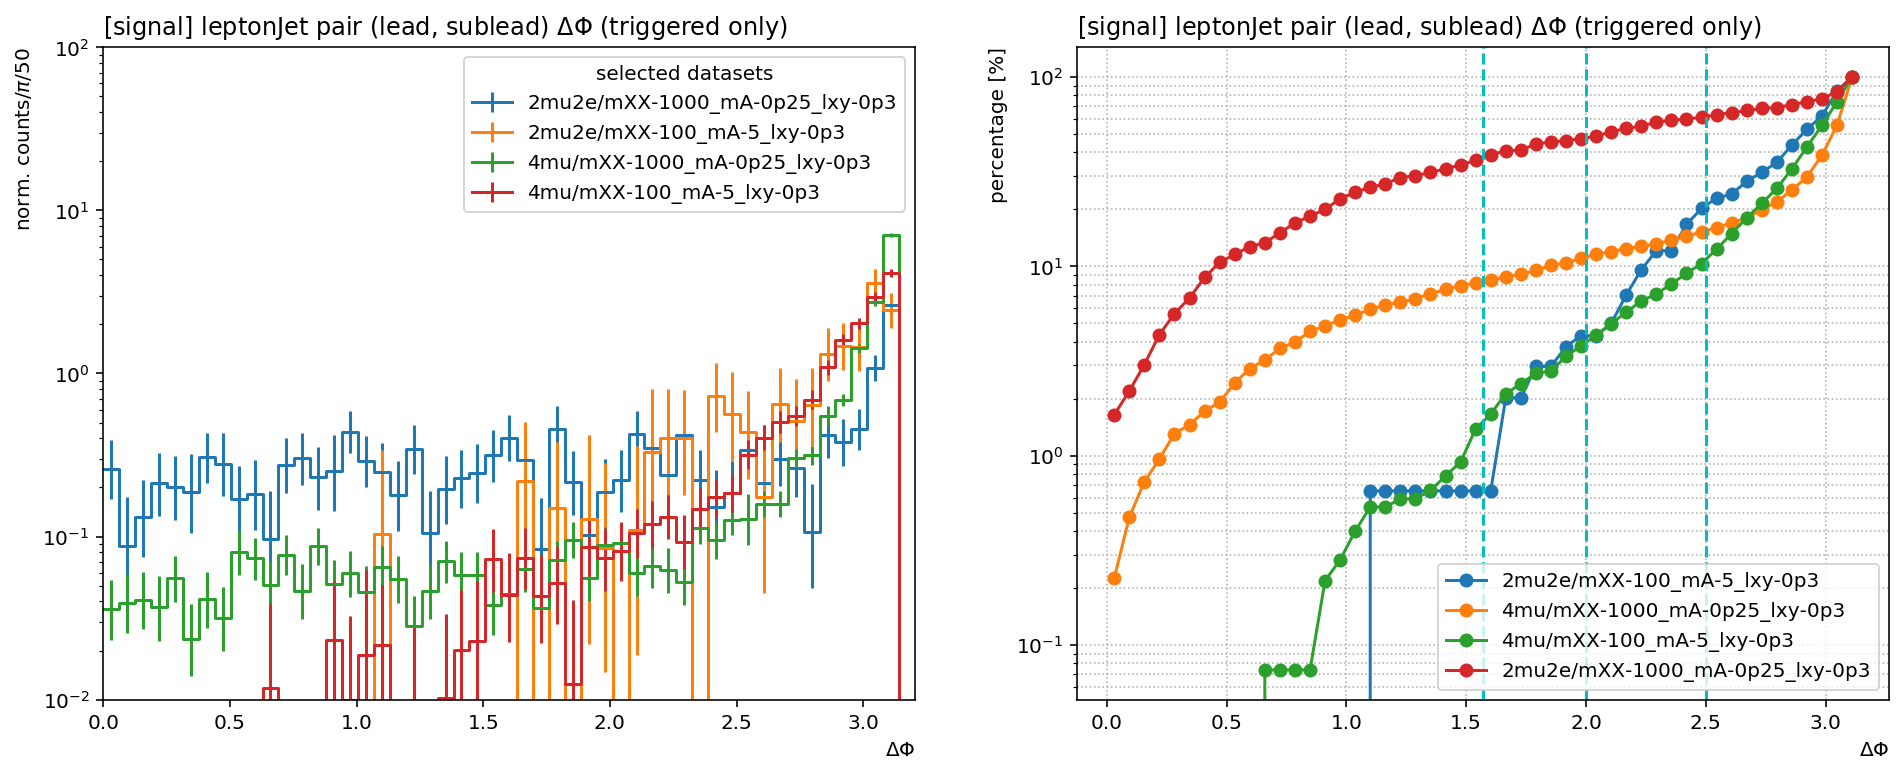

In [31]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['dphi'], overlay='dataset', ax=axes[0], density=True, overflow='over')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-2, 1e2])
axes[0].set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[0].set_xlabel(axes[0].get_xlabel(), x=1.0, ha="right")
axes[0].set_ylabel(axes[0].get_ylabel(), y=1.0, ha="right")

for d in output['dphi'].values():
    label_ = d[0]
    val = output['dphi'].values()[d]
    val_ = np.cumsum(val)/np.sum(val) * 100
    axes[1].plot(output['dphi'].axis('dphi').centers(), val_, marker='o', label=label_)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].grid(which='both', ls=':')
for i in [np.pi/2, 2, 2.5]:
    axes[1].axvline(i, color='c', ls='--') # cyan
axes[1].set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[1].set_xlabel('$\Delta\Phi$', x=1.0, ha="right")
axes[1].set_ylabel('percentage [%]', y=1.0, ha="right");

most separated leptonJet pairs

In [10]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'selected datasets')
        mass0_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 200) # small range
        mass1_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 2000) # large range
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass0': hist.Hist("norm. counts/4GeV", dataset_axis, mass0_axis),
            'mass1': hist.Hist("norm. counts/40GeV", dataset_axis, mass1_axis),
            'dphi': hist.Hist("norm. counts/$\pi$/50", dataset_axis, dphi_axis),
            'dphimass': hist.Hist("norm. counts/$\pi$/50/40GeV", dataset_axis, dphi_axis, mass1_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        dphi = np.abs(leptonjetpair.i0.p4.delta_phi(leptonjetpair.i1.p4))
        selectedpair = leptonjetpair[dphi.argmax()]
        
        output['mass0'].fill(dataset=dataset, mass=selectedpair.mass.flatten(), weight=wgt)
        output['mass1'].fill(dataset=dataset, mass=selectedpair.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi.max(), weight=wgt)
        output['dphimass'].fill(dataset=dataset, dphi=dphi.max(), mass=selectedpair.mass.flatten(), weight=wgt)

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [11]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  1.83items/s]


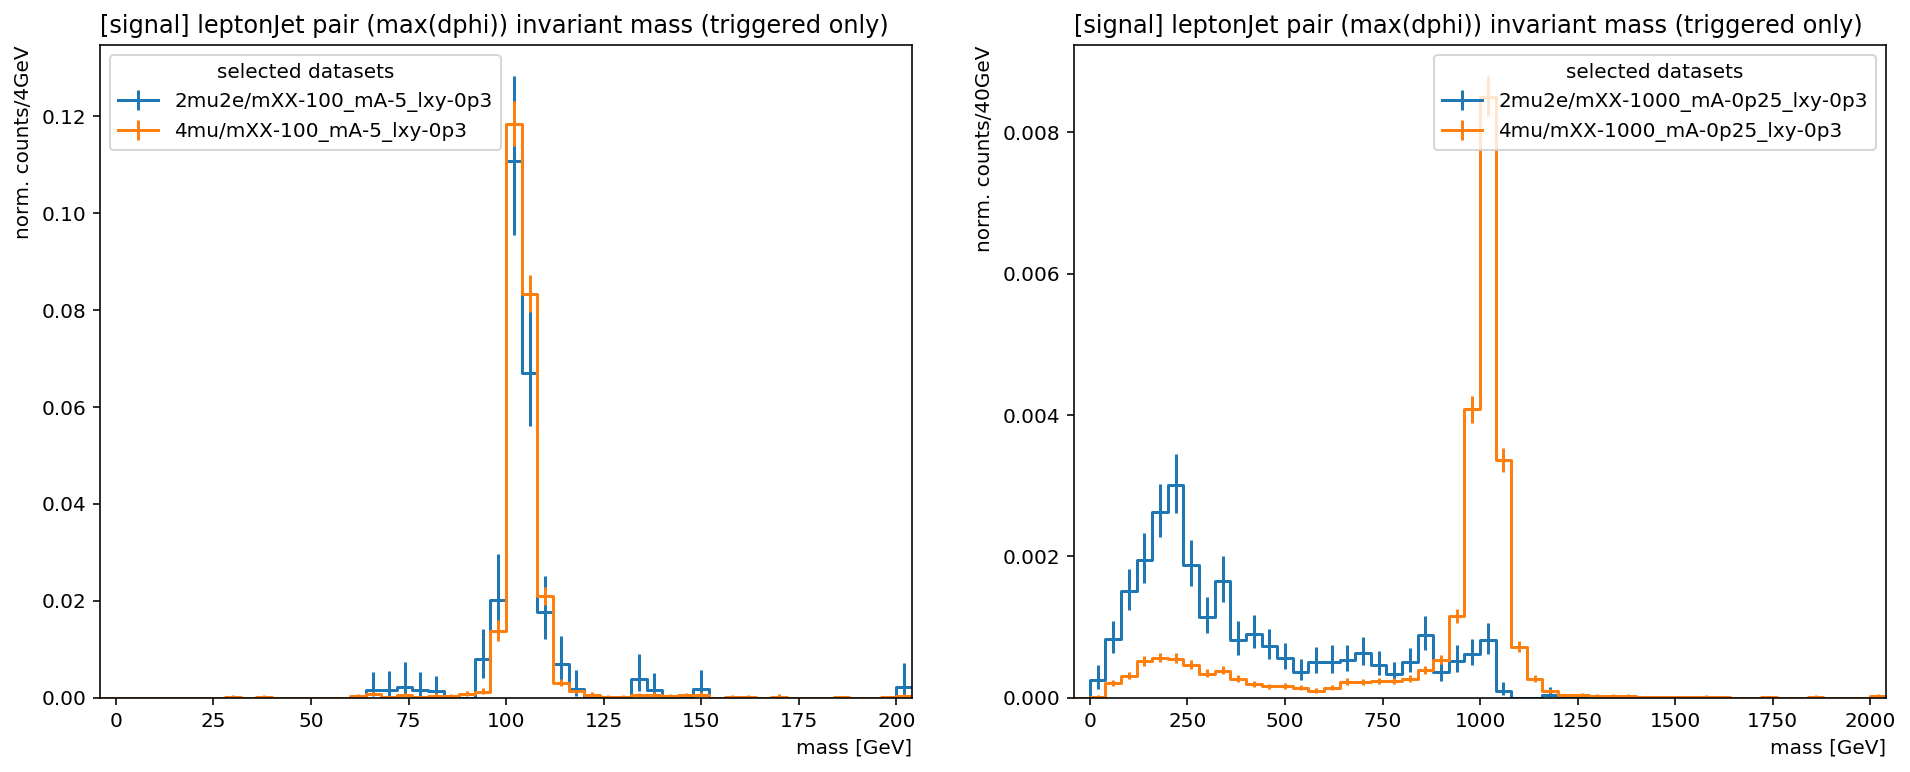

In [34]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig,ax,_ = hist.plot1d(output['mass0']['*/mXX-100_mA-5*'], overlay='dataset', ax=axes[0], density=True, overflow='all')
fig,ax,_ = hist.plot1d(output['mass1']['*/mXX-1000_mA-0p25*'], overlay='dataset', ax=axes[1], density=True, overflow='all')

for ax in axes:
#     ax.set_yscale('log')
    ax.set_title('[signal] leptonJet pair (max(dphi)) invariant mass (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

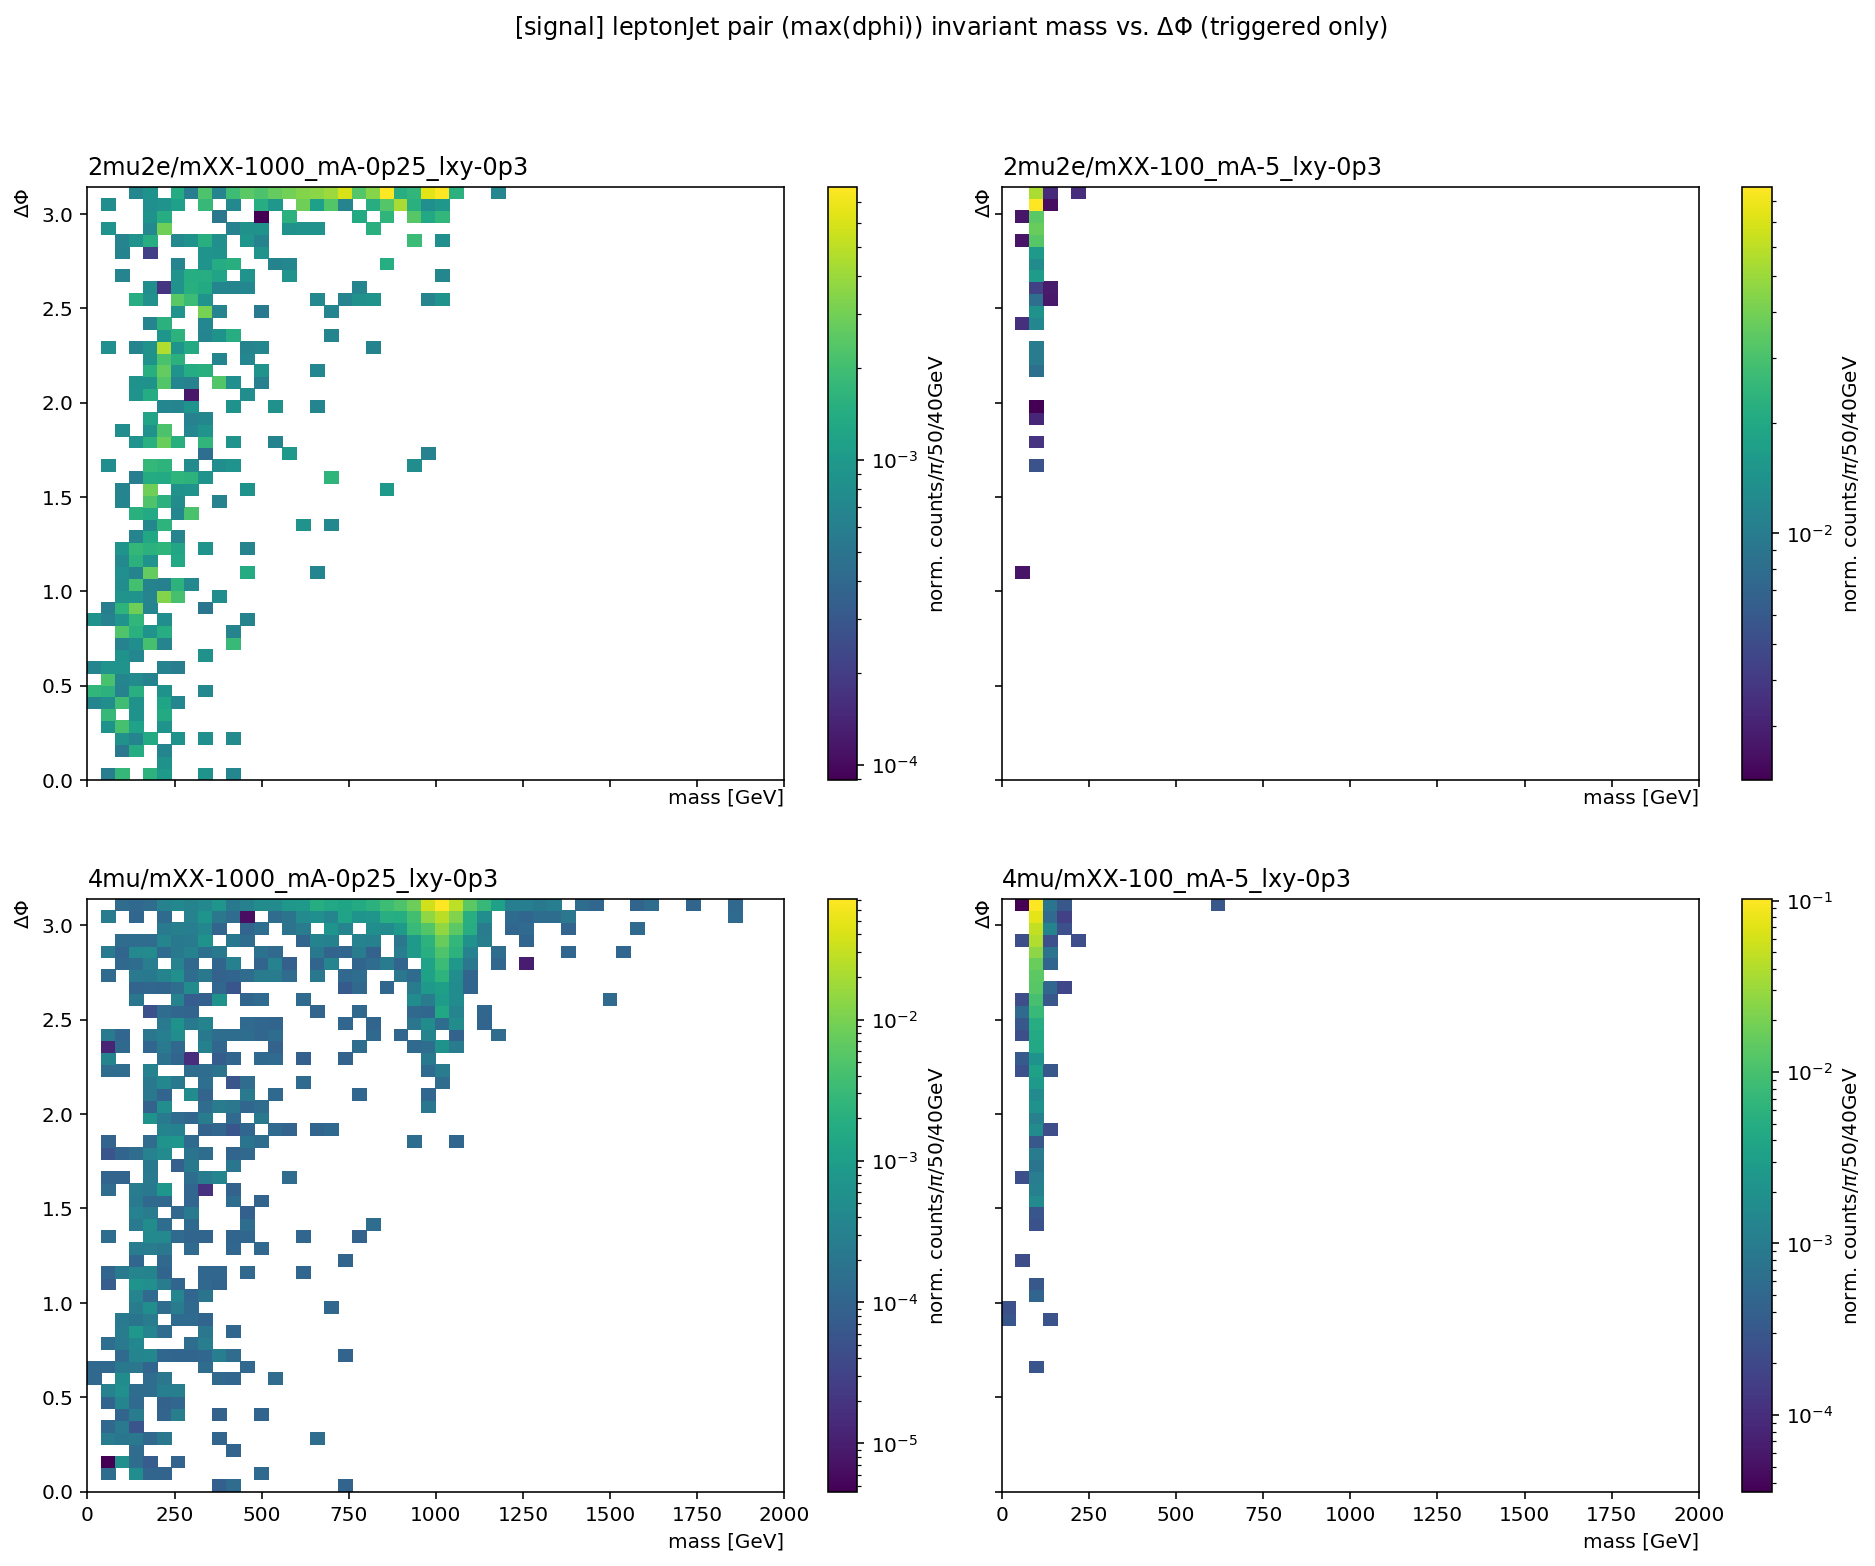

In [35]:
from matplotlib.colors import LogNorm
dsids = output['dphimass'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['dphimass'].project('dataset', dsids[i]), xaxis='mass', density=True, ax=ax, patch_opts=dict(norm=LogNorm()))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal] leptonJet pair (max(dphi)) invariant mass vs. $\Delta\Phi$ (triggered only)');

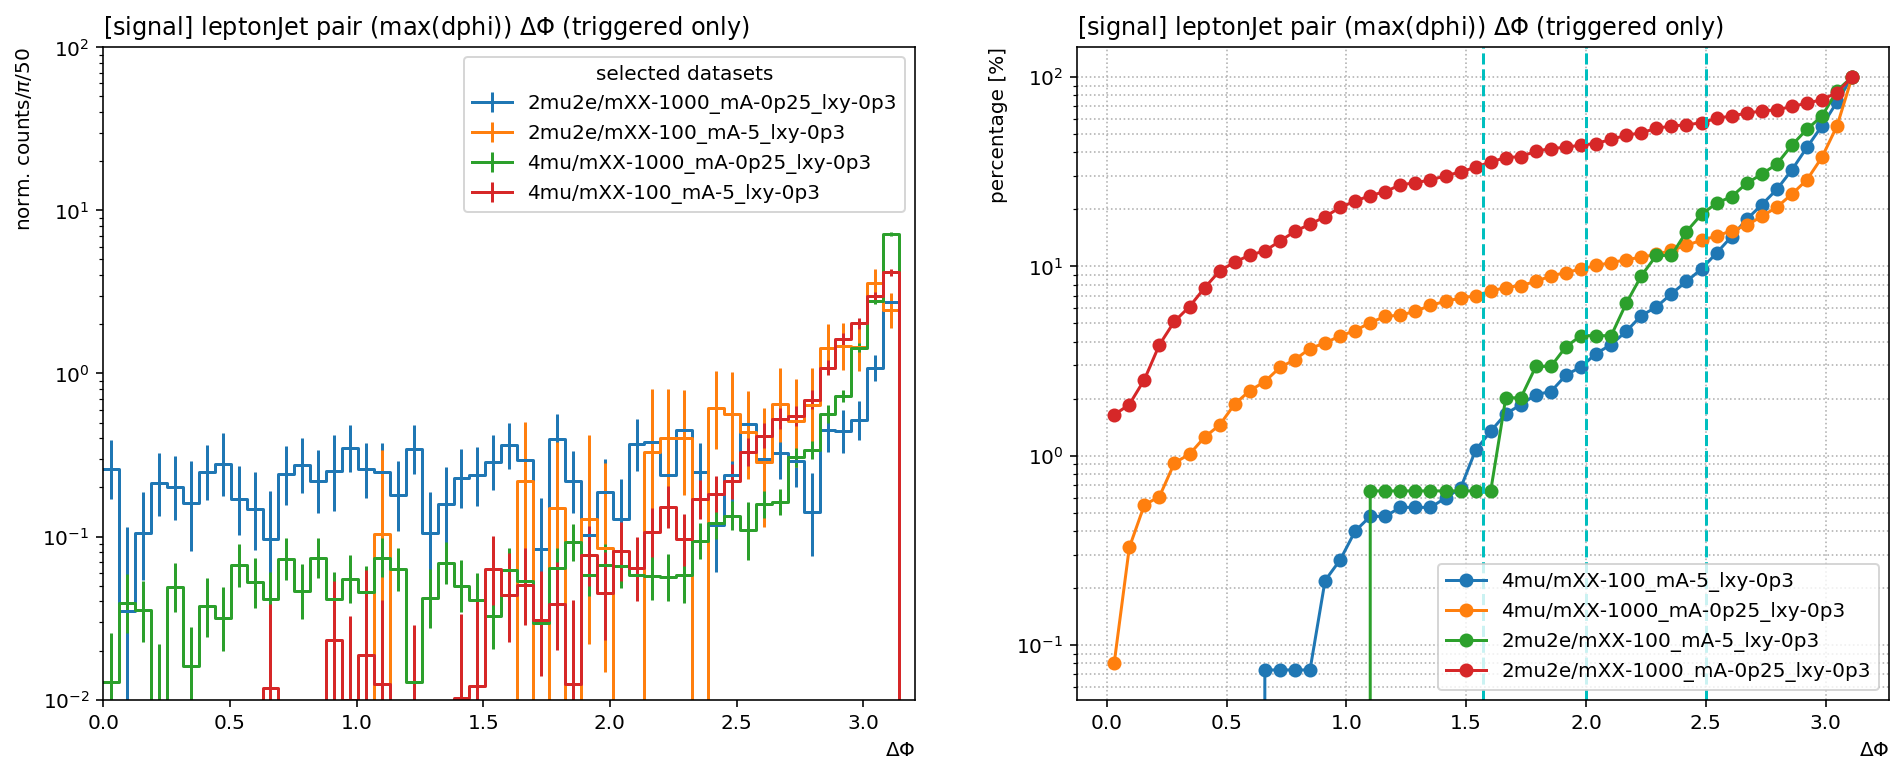

In [36]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['dphi'], overlay='dataset', ax=axes[0], density=True, overflow='over')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-2, 1e2])
axes[0].set_title('[signal] leptonJet pair (max(dphi)) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[0].set_xlabel(axes[0].get_xlabel(), x=1.0, ha="right")
axes[0].set_ylabel(axes[0].get_ylabel(), y=1.0, ha="right")

for d in output['dphi'].values():
    label_ = d[0]
    val = output['dphi'].values()[d]
    val_ = np.cumsum(val)/np.sum(val) * 100
    axes[1].plot(output['dphi'].axis('dphi').centers(), val_, marker='o', label=label_)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].grid(which='both', ls=':')
for i in [np.pi/2, 2, 2.5]:
    axes[1].axvline(i, color='c', ls='--') # cyan
axes[1].set_title('[signal] leptonJet pair (max(dphi)) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[1].set_xlabel('$\Delta\Phi$', x=1.0, ha="right")
axes[1].set_ylabel('percentage [%]', y=1.0, ha="right");

leading and most separated leptonjet pairs

In [12]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'selected datasets')
        mass0_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 200) # small range
        mass1_axis    = hist.Bin('mass', "mass [GeV]", 50, 0, 2000) # large range
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass0': hist.Hist("norm. counts/4GeV", dataset_axis, mass0_axis),
            'mass1': hist.Hist("norm. counts/40GeV", dataset_axis, mass1_axis),
            'dphi': hist.Hist("norm. counts/$\pi$/50", dataset_axis, dphi_axis),
            'dphimass': hist.Hist("norm. counts/$\pi$/50/40GeV", dataset_axis, dphi_axis, mass1_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leading = dileptonjets[dileptonjets.pt.argmax()]
        pairs_ = leading.cross(dileptonjets)
        pairs = pairs_[pairs_.i0!=pairs_.i1]
        dphi = np.abs(pairs.i0.p4.delta_phi(pairs.i1.p4))
        selectedpair = pairs[dphi.argmax()]
        
        output['mass0'].fill(dataset=dataset, mass=selectedpair.mass.flatten(), weight=wgt)
        output['mass1'].fill(dataset=dataset, mass=selectedpair.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi.max(), weight=wgt)
        output['dphimass'].fill(dataset=dataset, dphi=dphi.max(), mass=selectedpair.mass.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [13]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.62items/s]


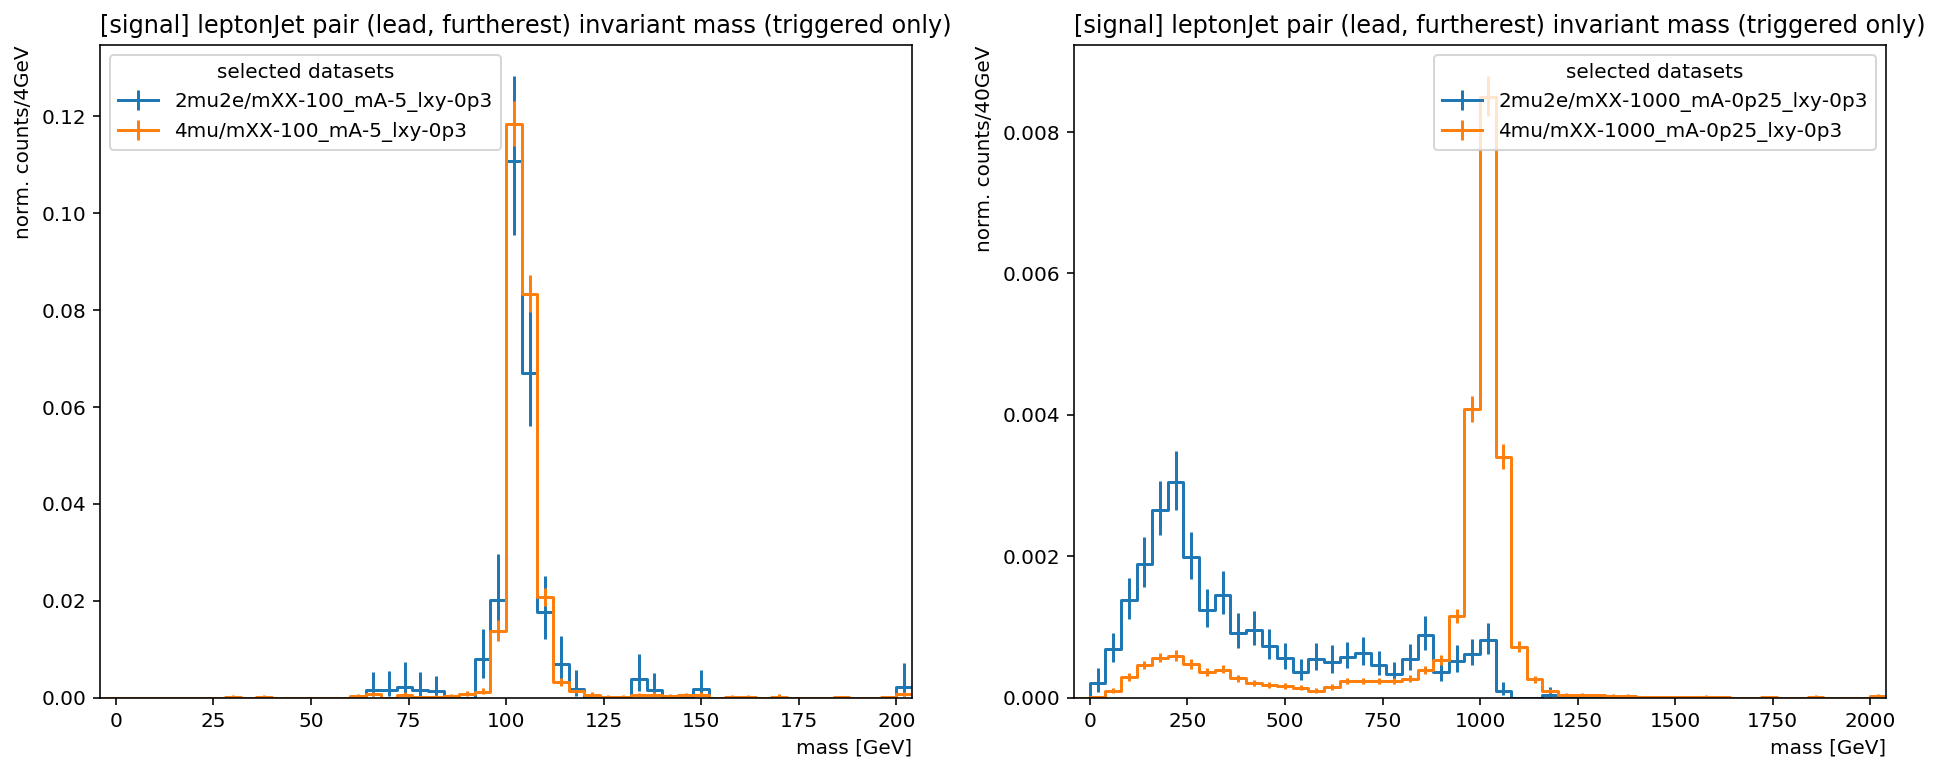

In [39]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig,ax,_ = hist.plot1d(output['mass0']['*/mXX-100_mA-5*'], overlay='dataset', ax=axes[0], density=True, overflow='all')
fig,ax,_ = hist.plot1d(output['mass1']['*/mXX-1000_mA-0p25*'], overlay='dataset', ax=axes[1], density=True, overflow='all')

for ax in axes:
#     ax.set_yscale('log')
    ax.set_title('[signal] leptonJet pair (lead, furtherest) invariant mass (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

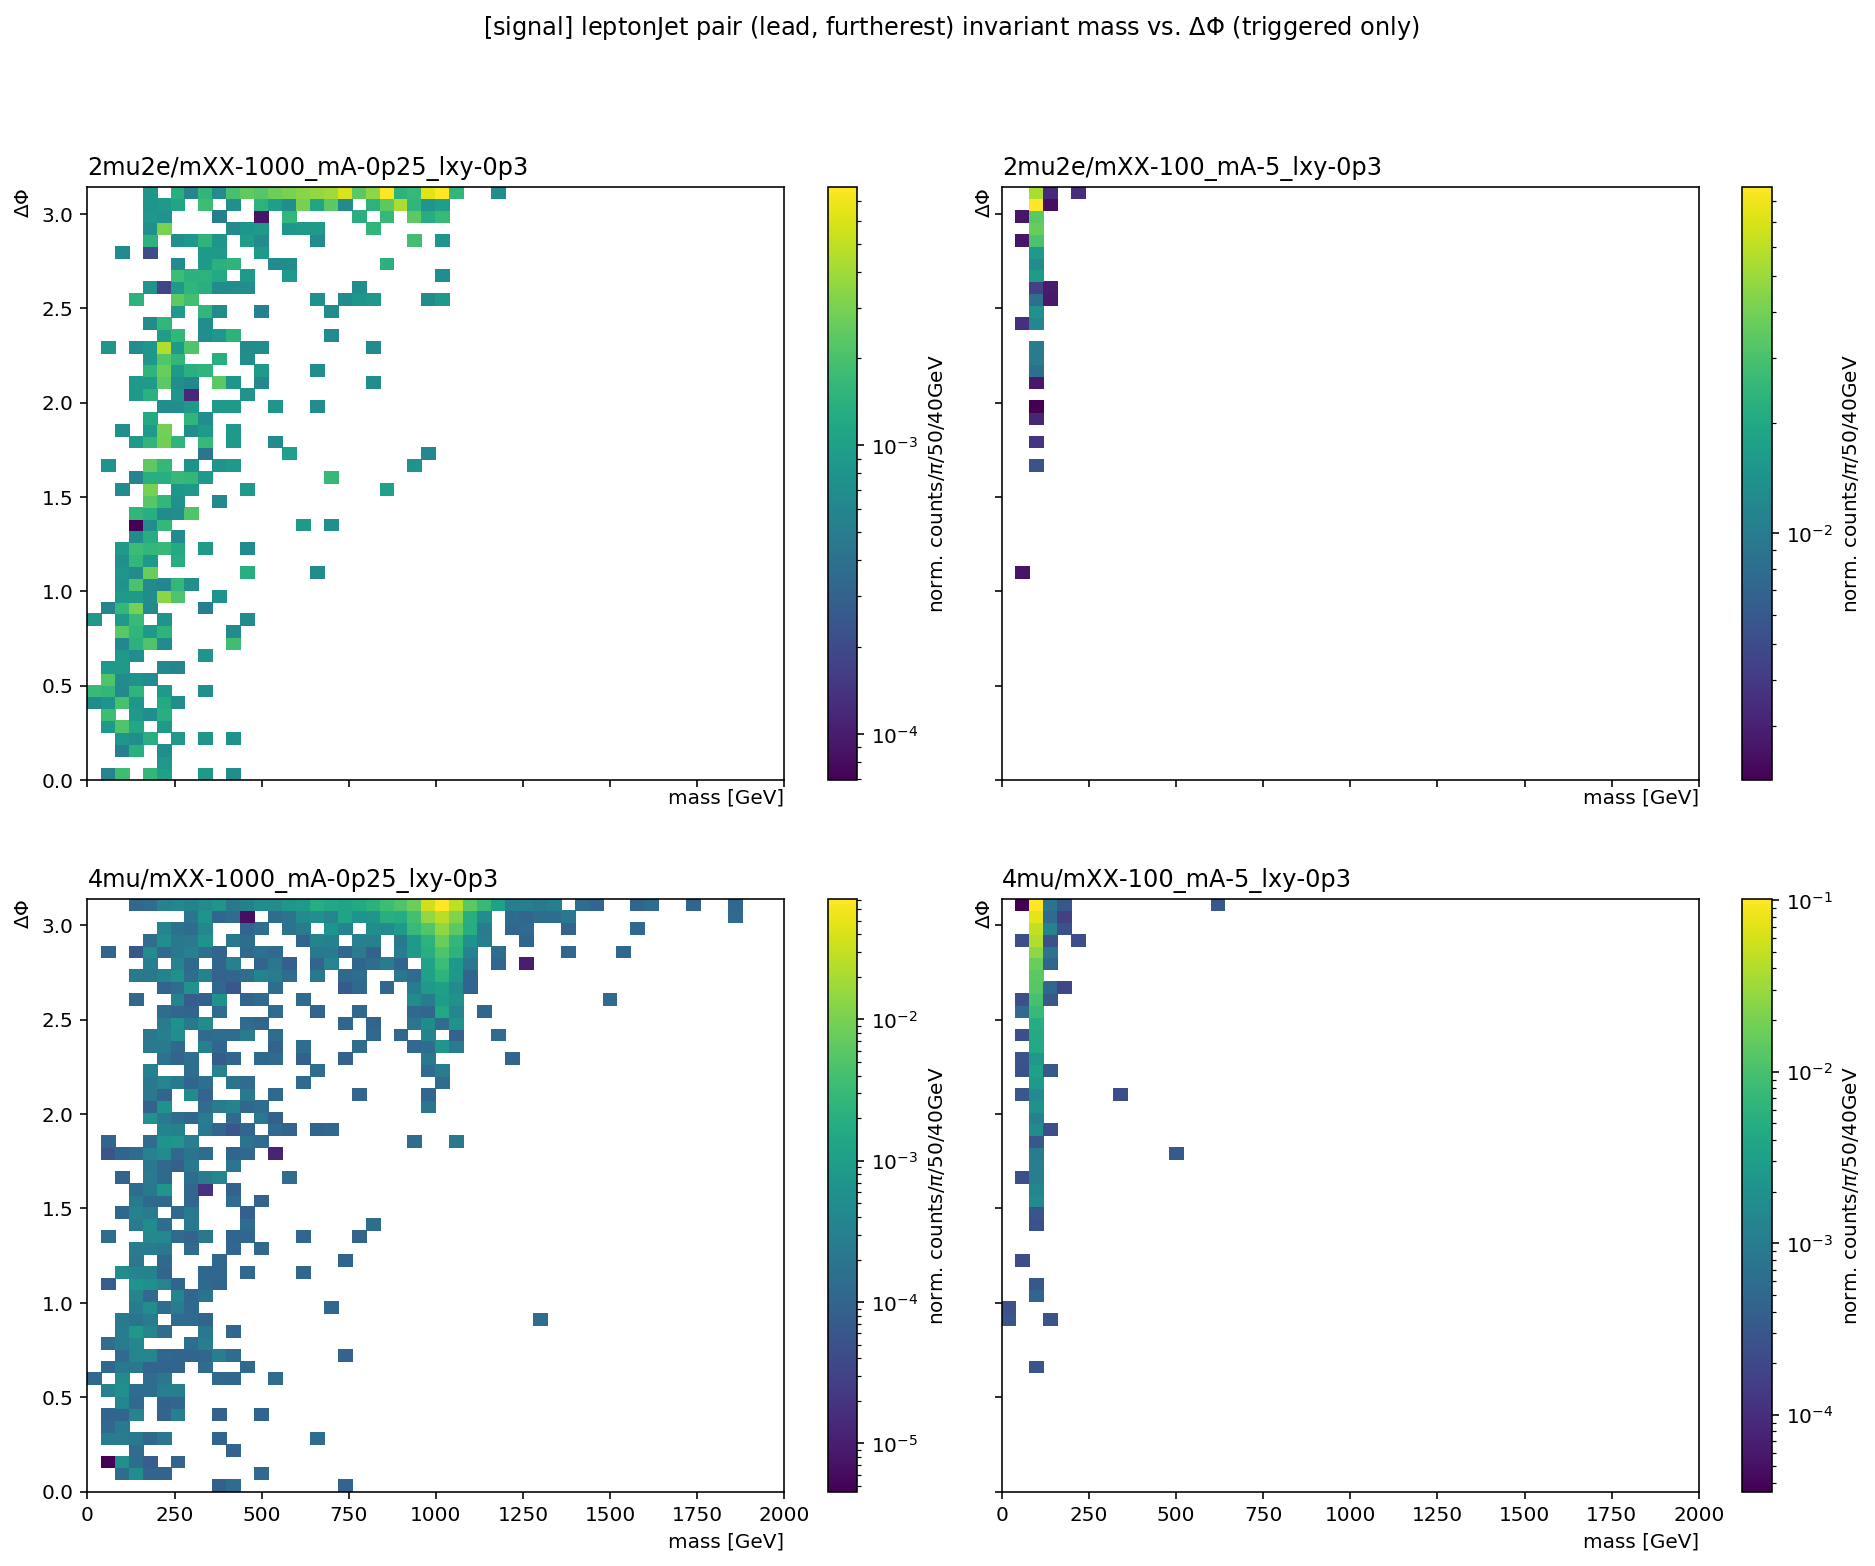

In [40]:
from matplotlib.colors import LogNorm
dsids = output['dphimass'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['dphimass'].project('dataset', dsids[i]), xaxis='mass', density=True, ax=ax, patch_opts=dict(norm=LogNorm()))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal] leptonJet pair (lead, furtherest) invariant mass vs. $\Delta\Phi$ (triggered only)');

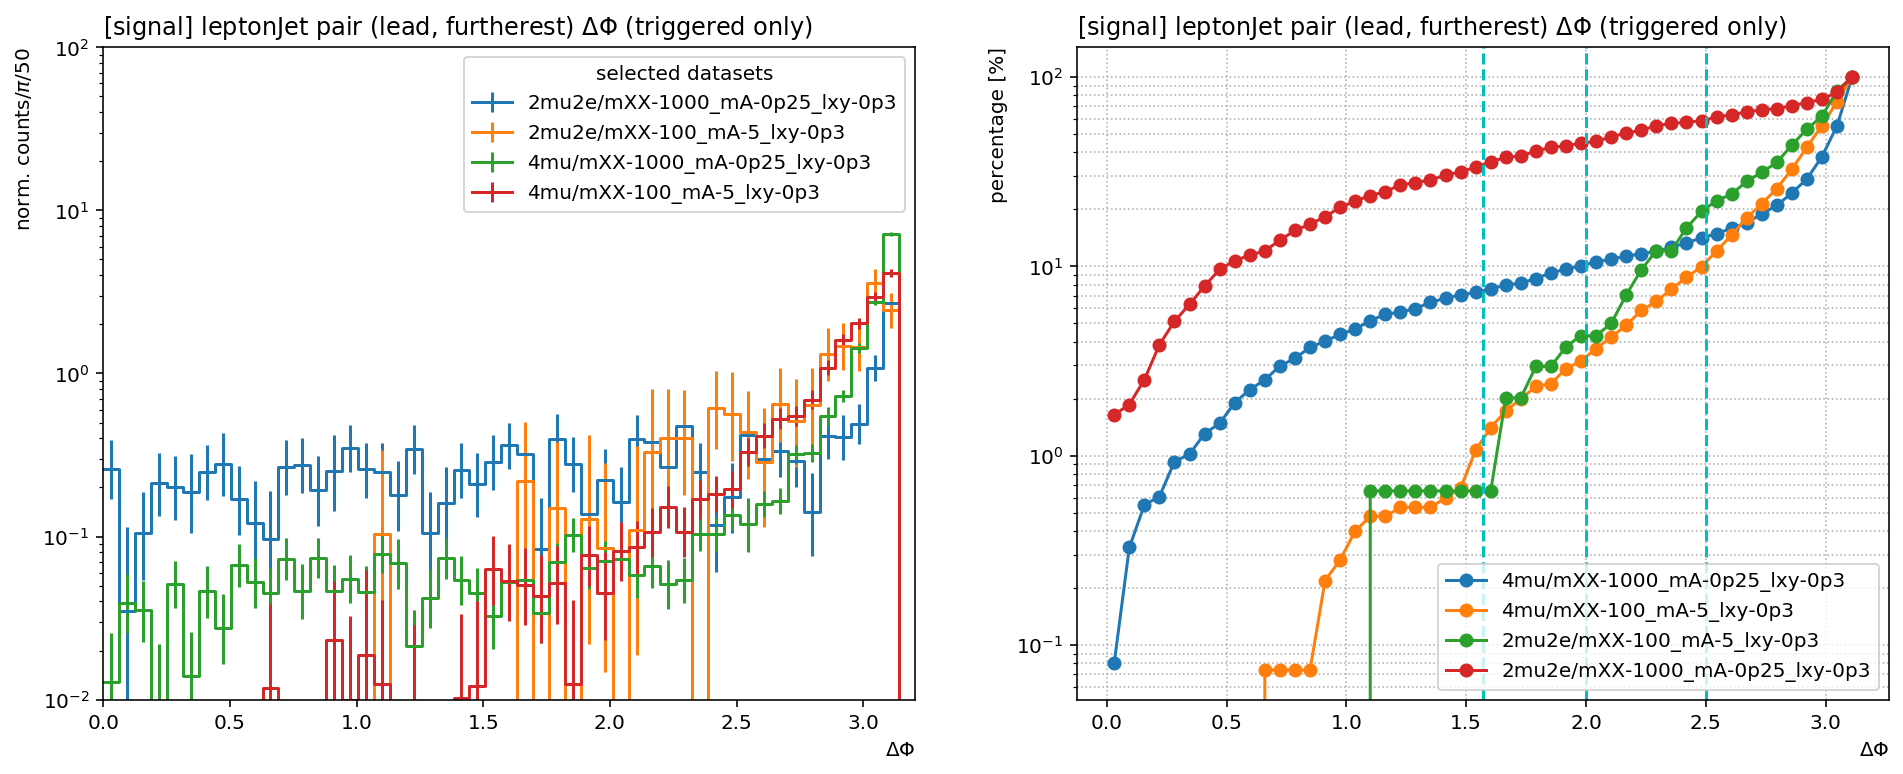

In [41]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['dphi'], overlay='dataset', ax=axes[0], density=True, overflow='over')

axes[0].set_yscale('log')
axes[0].set_ylim([1e-2, 1e2])
axes[0].set_title('[signal] leptonJet pair (lead, furtherest) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[0].set_xlabel(axes[0].get_xlabel(), x=1.0, ha="right")
axes[0].set_ylabel(axes[0].get_ylabel(), y=1.0, ha="right")

for d in output['dphi'].values():
    label_ = d[0]
    val = output['dphi'].values()[d]
    val_ = np.cumsum(val)/np.sum(val) * 100
    axes[1].plot(output['dphi'].axis('dphi').centers(), val_, marker='o', label=label_)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].grid(which='both', ls=':')
for i in [np.pi/2, 2, 2.5]:
    axes[1].axvline(i, color='c', ls='--') # cyan
axes[1].set_title('[signal] leptonJet pair (lead, furtherest) $\Delta\Phi$ (triggered only)', x=0.0, ha="left")
axes[1].set_xlabel('$\Delta\Phi$', x=1.0, ha="right")
axes[1].set_ylabel('percentage [%]', y=1.0, ha="right");

### Fractions of leading and subleading leptonJets to be matched with gen dark photons

In [14]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        match_axis   = hist.Bin('match', 'match', 2, 0, 2)
        order_axis   = hist.Cat('order', 'pT order')
        
        self._accumulator = processor.dict_accumulator({
            'matched': hist.Hist('#counts', dataset_axis, match_axis, order_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        darkphotons = darkphotons[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leadlj = dileptonjets[dileptonjets.pt.argmax()]
        subllj = dileptonjets[JaggedArray.fromfolding(dileptonjets.pt.argsort()[:,1],1)]
        
        output['matched'].fill(dataset=dataset, match=leadlj.match(darkphotons, deltaRCut=0.3).flatten(), order='leading', weight=wgt)
        output['matched'].fill(dataset=dataset, match=subllj.match(darkphotons, deltaRCut=0.3).flatten(), order='subleading', weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [15]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


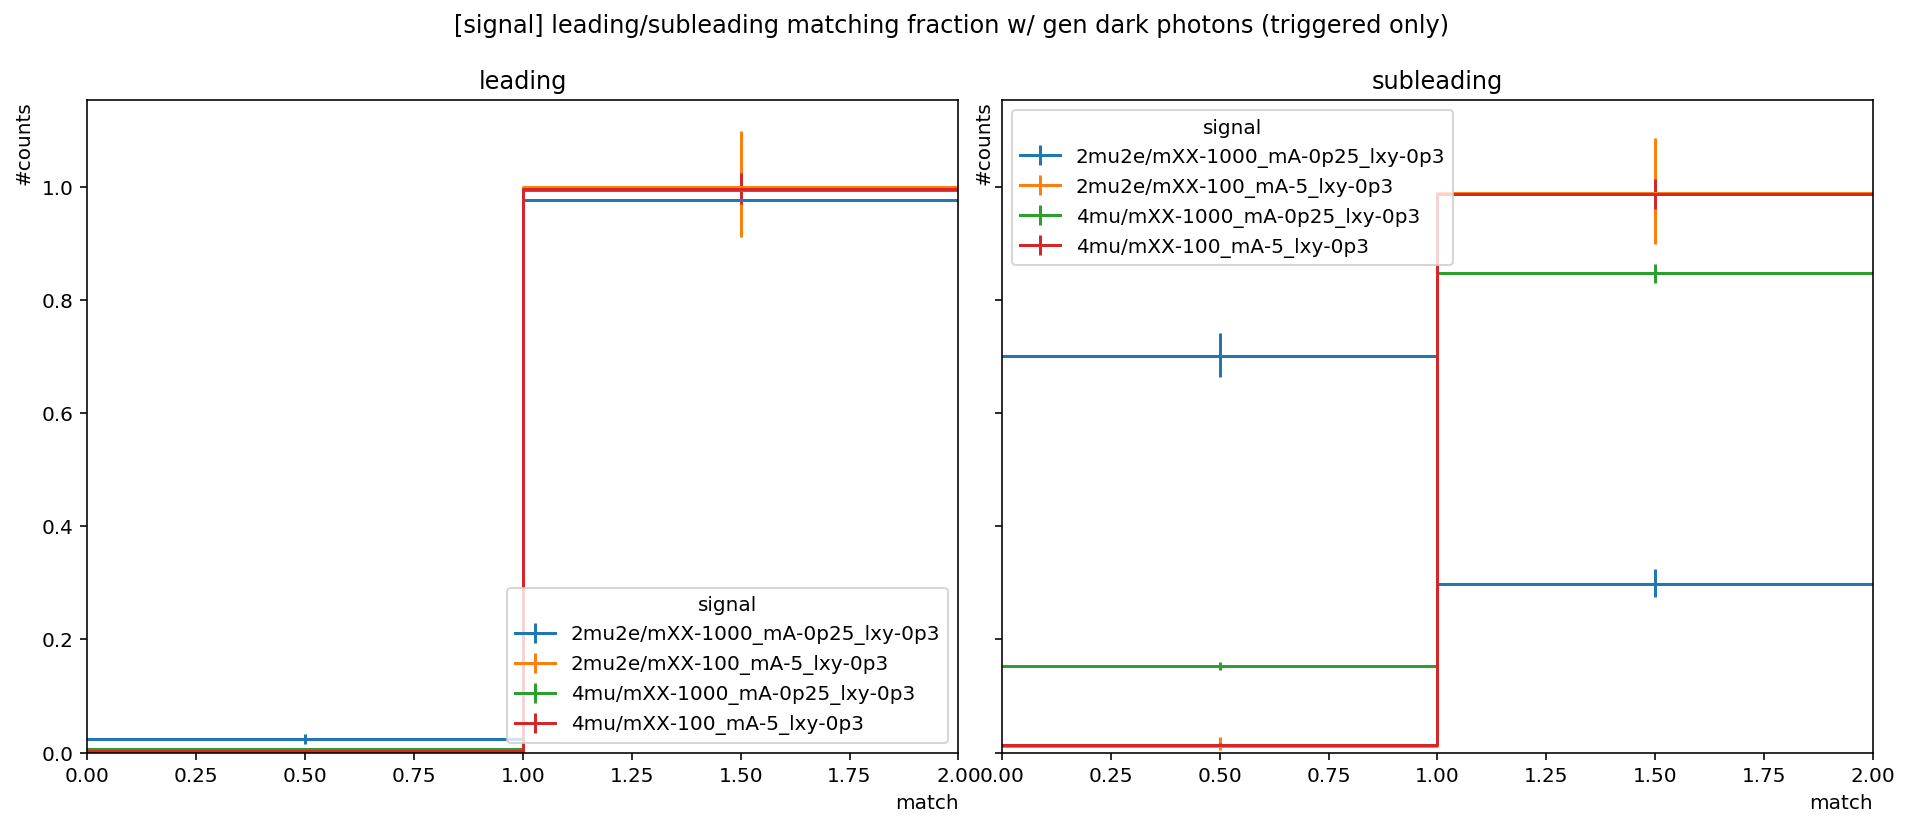

In [44]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.05}, sharey=True)
fig, axes = hist.plotgrid(output['matched'], col='order', figure=fig, overlay='dataset', density=True )
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal] leading/subleading matching fraction w/ gen dark photons (triggered only)');

consider the probability of leading two leptonJets matched with darkphotons when both darkphotons are well-reconstructed (can be matched)

[issue#7](https://github.com/phylsix/FireHydrant/issues/7)

In [16]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        match_axis   = hist.Bin('match', 'match', 2, 0, 2)
        order_axis   = hist.Cat('order', 'pT order')
        
        self._accumulator = processor.dict_accumulator({
            'matched': hist.Hist('#counts', dataset_axis, match_axis, order_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        darkphotons = darkphotons[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        ## ensure both darkphotons are well-reconstructed
        mask_ = darkphotons.match(dileptonjets, deltaRCut=0.3).all()
        dileptonjets = dileptonjets[mask_]
        darkphotons = darkphotons[mask_]
        wgt = wgt[mask_]
        
        leadlj = dileptonjets[dileptonjets.pt.argmax()]
        subllj = dileptonjets[JaggedArray.fromfolding(dileptonjets.pt.argsort()[:,1],1)]
        
        output['matched'].fill(dataset=dataset, match=leadlj.match(darkphotons, deltaRCut=0.3).flatten(), order='leading', weight=wgt)
        output['matched'].fill(dataset=dataset, match=subllj.match(darkphotons, deltaRCut=0.3).flatten(), order='subleading', weight=wgt)

        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [17]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  1.04s/items]


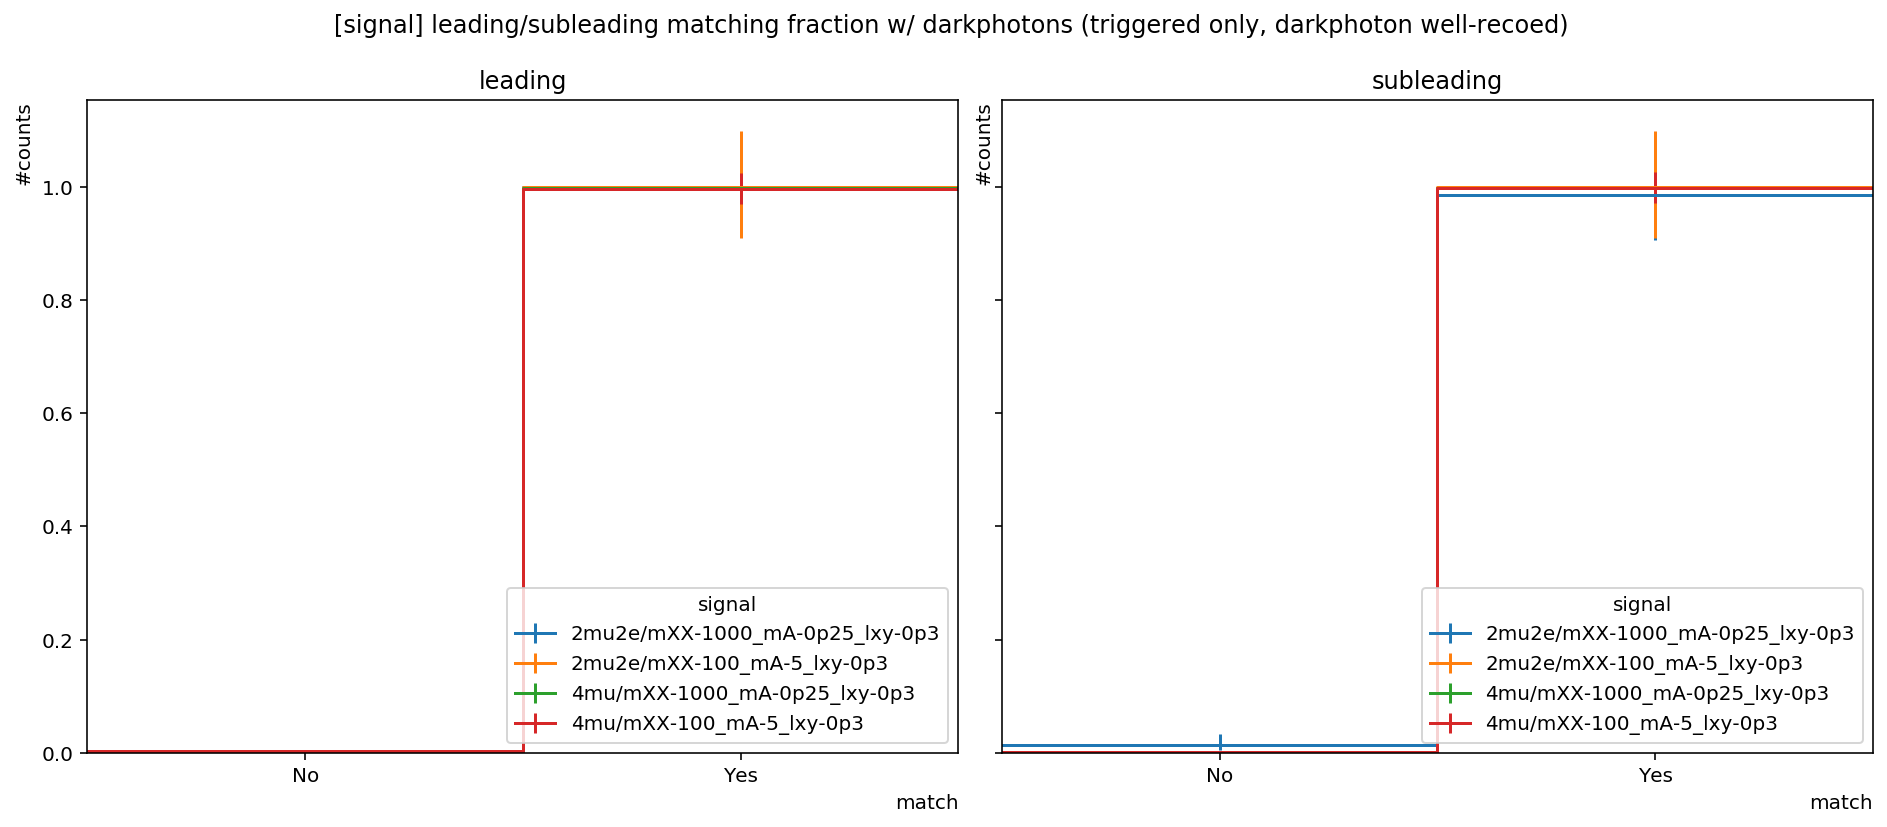

In [48]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.05}, sharey=True)
fig, axes = hist.plotgrid(output['matched'], col='order', figure=fig, overlay='dataset', density=True )
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['No', 'Yes'])
plt.suptitle('[signal] leading/subleading matching fraction w/ darkphotons (triggered only, darkphoton well-recoed)');